# COGS 108 - Final Project 

# Overview

Nowadays the internet affects every aspect of our lives. However, there are still people living without the internet in different corners of the world. This project is an analysis on the relationship between certain socioeconomic fators and overall internet usage across different United States Counties. While the datasets that are analyzed contain a wide array of information, the goal is to extrapolate hidden relationships and understand variables that may have been overlooked at first glance. By cleaning the data, as well as graphing and analyzing certain information, the underlying reason behind such disparities and inequity becomes clearer.

# Group Member's IDs

- A14711559 Jialiang Ji, jij106@ucsd.edu
- A13718465 Yabo Shi, yas089@ucsd.edu
- A14779494 Tram Nguyen thn099@ucsd.edu
- A14933874 Kegan Wong, kmw037@ucsd.edu
- A14886063 Leyi Shang, leshang@ucsd.edu

## Background and Prior Work

The American Community Survey (ACS) is a yearly survey which collects data about the United States, covering various fields such as education and employment. Since 2013, the survey started asking questions about internet usage. These statistics were organized together and published by the end of each year. In 2016, the survey reported that in Douglas County, about 5% of U.S households surveyed did not have a computer, and 10% of U.S households surveyed did not have an internet subscription. This is especially surprising considering that technology is heavily integrated in current day.

<br>
In 2018, the Pew Research Center produced a chart to visualize internet usage in the U.S, but the details of the data were hidden and no analysis was provided. From the chart, we can only infer some basic characteristics of people without internet, such as being over the age of 65, having an annual income below 30k, failing to attend highschool, or living in a rural region. However, to bolster these findings, another report written by Camille Ryan in the same year suggested that there were some regional differences across the country. But his report mainly focused more on comparing and contrasting the sets of survey questions instead of exploring the correlation between region, and internet usage.
<br>

The prior works only give broad conclusions and fail to address the details of internet usage across United State's regions. We aim to expand on the topic and thoroughly explore how internet usage changes across region. Furthermore, we will try to develop a relationship between different socioeconomic factors such as education levels and income with overall internet usage. This question is important to our group because the internet is a valuable source to obtain information and connect with others. The fact that this topic has been relatively unexplored is concerning, since every citizen should have the right to access and obtain information. Our motivation comes from the gaps from the surveys and research currently obtained, and we hope to build upon this topic to spread awareness. 

Reference: 
- 1) American fact finder: TYPES OF COMPUTERS AND INTERNET SUBSCRIPTIONS  https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_S2801&prodType=table
- 2) Pew Research Center: 11% of Americans don’t use the internet. Who are they? <br>
https://www.pewresearch.org/fact-tank/2018/03/05/some-americans-dont-use-the-internet-who-are-they/
- 3) United States Census:Computer and Internet Use in the United States: 2016 <br>
https://www.census.gov/library/publications/2018/acs/acs-39.html

# Research Question

Definition: <br>
We define socioeconomic levels to be anything related to social and economic qualities of a region (in our case a county). This can include age, average household income, education and poverty levels, and population density. <br>

Question of Interest: <br>
What is the relationship between overall internet usage and socioeconomic levels across geographic counties in the United States, and how can this be used to understand the underlying causes of internet disparities within the United States? 


# Hypothesis


We predict that low socioeconomic levels have a strong negative correlation with the county's internet usage. In other words, if a county has a relatively low average in post high school students, it might lead to a lower average of household income, and with a lower average of household income, it decreases the overall povery level of the county. Provided that technology is expensive, residents in each county would likely not be able to afford such devices and internet providers. Similarly, a population with an older population and a lower population density will have no need for internet and its corresponding devices, as lower population densitities are usually less urbanized, and the older generations did not grow up with internet.



# Dataset(s)

-1. Dataset Name: Kaggle_internet.csv
- Link to the dataset: https://www.kaggle.com/madaha/people-without-internet?fbclid=IwAR1AU733ujLR35XlWMy4fyhiNOaOZ_A62CucqdJZgAuf-4-88OcOh5gt8Dc#kaggle_internet.csv
- Number of observations: 820
- For this dataset, it describe the different precentage of internet for 820 cities. This DataSet also gives the ethnic distribution and education level of different cities.


-2. Dataset Name: Small Area Income and Poverty Estimates (SAIPE)
- Link to the dataset:https://www.census.gov/data-tools/demo/saipe/#/?map_geoSelector=mhi_c&s_year=2017&s_measures=mhi_snc&s_state=
- Number of observations: 3192
- This DataSet gives the Poverty Rate and Income for different cities.



-3. Dataset Name ： states_21baisc
- Link to the dataset: https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5
- This dataset contains files including state names, state sub regions, state abbreviation, and  polygon dataset that is used to map out the US states with GeoPandas.



# Setup

In [1]:
# makes sure all libraries are installed and up to date
!pip install --user descartes
!pip install --user geopandas
!pip install --user --upgrade numpy

# Import the libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import datetime
import geopandas as gpd
import seaborn as sns
import shapely.geometry as shp
import sklearn.neighbors as skn
import sklearn.metrics as skm

# Significance Test
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# NLP
import re
from nltk.corpus import stopwords

#linear regression 
from sklearn.linear_model import LinearRegression
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_rows = 10

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory 

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

There are certain columns that are not important to the question at hand. Furthermore, some information needs to be merged to gain a deeper insight to our question. In order to make our information as concise and relevant as possible, some information needs to be deleted, and some information needs to be merged. <br>

We use sqlite to merge these two dataset together.
1. Download the first two dataset.
2. Open the csv file in the DB broser.
3. Use terminal to open the database.
4. Change the Kaggle_internet's column name: merge the "county" and "state" together by 'UPDATE TABLE' commend to create a new column which name is "countyState".
5. Use 'Create Table new Select a.*, b.* from Kaggle_internet a, SAIPE b where a.countyState=b.Name' to Create a new Database which name is "new".
6. Next we are going to delete the null values with python.

We used python to delete irrelevant information.
1. Drop columns that did not pertain to the question.
2. Search for na values, and dropped them.


In [2]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
# Load the dataset 
df = pd.read_csv("./new.csv")
df.head(n=20)

,countyState,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,...,UnderAge5inPovertyCountUB90%,90%ConfidenceInterval(UnderAge5inPovertyCount),UnderAge5inPovertyPercent,UnderAge5inPovertyPercentLB90%,UnderAge5inPovertyPercentUB90%,90%ConfidenceInterval(UnderAge5inPovertyPercent),MedianHouseholdIncomeinDollars,MedianHouseholdIncomeinDollarsLB90%,MedianHouseholdIncomeinDollarsUB90%,90%ConfidenceInterval(MedianHouseholdIncomeinDollars)
0,Fairbanks North Star Borough (AK),05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$74,241","$68,171","$80,311","$68,171 to $80,311"
1,Matanuska-Susitna Borough (AK),05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$72,296","$67,381","$77,211","$67,381 to $77,211"
2,Baldwin County (AL),05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$56,607","$52,439","$60,775","$52,439 to $60,775"
3,Calhoun County (AL),05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"$45,937","$43,419","$48,455","$43,419 to $48,455"
4,Cullman County (AL),05000US01043,-86.869267,34.131923,82471,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"$45,925","$41,985","$49,865","$41,985 to $49,865"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Mobile County (AL),05000US01097,-88.196568,30.684573,414836,243284.0,148001.0,8269.0,3328.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$45,615","$42,959","$48,271","$42,959 to $48,271"
16,Montgomery County (AL),05000US01101,-86.203831,32.203651,226349,81740.0,130006.0,5753.0,339.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$45,833","$43,205","$48,461","$43,205 to $48,461"
17,Morgan County (AL),05000US01103,-86.846402,34.454484,119012,93591.0,14431.0,1076.0,763.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$49,274","$45,438","$53,110","$45,438 to $53,110"
18,St. Clair County (AL),05000US01115,-86.315663,33.712963,88019,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"$52,755","$49,054","$56,456","$49,054 to $56,456"


In [3]:
# drop irrevalent columns
df.drop(['UnderAge5inPovertyCountLB90%','UnderAge5inPovertyCount','UnderAge5SAIPEPovertyUniverse','90%ConfidenceInterval(UnderAge5inPovertyPercent)','UnderAge5inPovertyPercentUB90%','UnderAge5inPovertyPercentLB90%','UnderAge5inPovertyPercent','UnderAge5inPovertyCountUB90%','90%ConfidenceInterval(UnderAge5inPovertyCount)'], axis=1, inplace=True)

df.head(n=20)

,countyState,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,...,Ages5to17inFamiliesinPovertyCountUB90%,90%ConfidenceInterval(Ages5to17inFamiliesinPovertyCount),Ages5to17inFamiliesinPovertyPercent,Ages5to17inFamiliesinPovertyPercentLB90%,Ages5to17inFamiliesinPovertyPercentUB90%,90%ConfidenceInterval(Ages5to17inFamiliesinPovertyPercent),MedianHouseholdIncomeinDollars,MedianHouseholdIncomeinDollarsLB90%,MedianHouseholdIncomeinDollarsUB90%,90%ConfidenceInterval(MedianHouseholdIncomeinDollars)
0,Fairbanks North Star Borough (AK),05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,...,1728,"928 to 1,728",8.5,5.9,11.1,5.9 to 11.1,"$74,241","$68,171","$80,311","$68,171 to $80,311"
1,Matanuska-Susitna Borough (AK),05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,...,2712,"1,752 to 2,712",10.9,8.5,13.3,8.5 to 13.3,"$72,296","$67,381","$77,211","$67,381 to $77,211"
2,Baldwin County (AL),05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,...,6101,"3,641 to 6,101",14.3,10.7,17.9,10.7 to 17.9,"$56,607","$52,439","$60,775","$52,439 to $60,775"
3,Calhoun County (AL),05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,...,4976,"3,066 to 4,976",22.2,16.9,27.5,16.9 to 27.5,"$45,937","$43,419","$48,455","$43,419 to $48,455"
4,Cullman County (AL),05000US01043,-86.869267,34.131923,82471,NaN,NaN,NaN,NaN,NaN,...,3072,"1,790 to 3,072",18.3,13.5,23.1,13.5 to 23.1,"$45,925","$41,985","$49,865","$41,985 to $49,865"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Mobile County (AL),05000US01097,-88.196568,30.684573,414836,243284.0,148001.0,8269.0,3328.0,20.0,...,23356,"17,636 to 23,356",29.5,25.4,33.6,25.4 to 33.6,"$45,615","$42,959","$48,271","$42,959 to $48,271"
16,Montgomery County (AL),05000US01101,-86.203831,32.203651,226349,81740.0,130006.0,5753.0,339.0,36.0,...,13684,"10,198 to 13,684",31.8,27.2,36.4,27.2 to 36.4,"$45,833","$43,205","$48,461","$43,205 to $48,461"
17,Morgan County (AL),05000US01103,-86.846402,34.454484,119012,93591.0,14431.0,1076.0,763.0,0.0,...,4633,"2,885 to 4,633",19.0,14.6,23.4,14.6 to 23.4,"$49,274","$45,438","$53,110","$45,438 to $53,110"
18,St. Clair County (AL),05000US01115,-86.315663,33.712963,88019,NaN,NaN,NaN,NaN,NaN,...,3047,"1,837 to 3,047",16.7,12.6,20.8,12.6 to 20.8,"$52,755","$49,054","$56,456","$49,054 to $56,456"


In [4]:
#df.drop(['StateCountyName', 'CountyID', 'State', 'Year', 'P_below_poverty','P_bachelor_and_above','P_some_college','P_high_school_equivalent','P_some_high_school','P_below_middle_school','lat','lon','GEOID'], axis=1, inplace=True)
df.drop(['CountyID', 'Year','lat','lon','GEOID', 'P_white','P_black','P_asian','P_native','P_hawaiian','P_others',
         'AllAgesinPovertyCountLB90%','AllAgesinPovertyCountUB90%','90%ConfidenceInterval(AllAgesinPovertyCount)',
         'AllAgesinPovertyPercentLB90%','AllAgesinPovertyPercentUB90%','90%ConfidenceInterval(AllAgesinPovertyPercent)',
        'UnderAge18inPovertyCountLB90%','UnderAge18inPovertyCountUB90%','90%ConfidenceInterval(UnderAge18inPovertyCount)',
        'Ages5to17inFamiliesinPovertyCountLB90%','Ages5to17inFamiliesinPovertyCountUB90%','90%ConfidenceInterval(Ages5to17inFamiliesinPovertyCount)',
        'Ages5to17inFamiliesinPovertyPercentLB90%','Ages5to17inFamiliesinPovertyPercentUB90%','90%ConfidenceInterval(Ages5to17inFamiliesinPovertyPercent)',
        'MedianHouseholdIncomeinDollarsLB90%','MedianHouseholdIncomeinDollarsUB90%','90%ConfidenceInterval(MedianHouseholdIncomeinDollars)',
        'UnderAge18inPovertyPercentLB90%','UnderAge18inPovertyPercentUB90%','median_rent_per_income','90%ConfidenceInterval(UnderAge18inPovertyPercent)'],
         axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 24 columns):
countyState                                816 non-null object
P_total                                    816 non-null int64
P_below_middle_school                      814 non-null float64
P_some_high_school                         814 non-null float64
P_high_school_equivalent                   814 non-null float64
P_some_college                             814 non-null float64
P_bachelor_and_above                       814 non-null float64
P_below_poverty                            816 non-null int64
median_age                                 816 non-null float64
gini_index                                 816 non-null float64
median_household_income                    816 non-null int64
percent_no_internet                        816 non-null float64
State                                      816 non-null int64
StateCountyName                            816 non-null object
AllAgesSA

For our research question, we choose to use these columns:
1. county: name of the county
2. state: abbreviation of the state where the county is in
3. P_total: total population
4. P_below_middle_school: population with education at or below 8th grade
5. P_some_high_school: population having some years in high school but without a diploma
6. P_high_school_equivalent: population with high school diploma or equivalent
7. P_some_college: Population having associate degree or some years in college without bachelor degree
8. P_bachelor_and_above: population with bachelor, master, professional, or doctor degrees
9. P_below_poverty: population living below poverty line
10. median_age: median age of population
11. gini_index: gini index
12. median_household_income: median household income
13. percent_no_internet: percent of household without internet connection


In [6]:
df.head(n=800)

,countyState,P_total,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,...,AllAgesSAIPEPovertyUniverse,AllAgesinPovertyCount,AllAgesinPovertyPercent,UnderAge18SAIPEPovertyUniverse,UnderAge18inPovertyCount,UnderAge18inPovertyPercent,Ages5to17inFamiliesSAIPEPovertyUniverse,Ages5to17inFamiliesinPovertyCount,Ages5to17inFamiliesinPovertyPercent,MedianHouseholdIncomeinDollars
0,Fairbanks North Star Borough (AK),100605,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,...,94772,7051,7.4,23191,2095,9.0,15657,1328,8.5,"$74,241"
1,Matanuska-Susitna Borough (AK),104365,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,...,103931,11768,11.3,28054,3559,12.7,20402,2232,10.9,"$72,296"
2,Baldwin County (AL),208563,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,...,209922,21199,10.1,45790,6734,14.7,34058,4871,14.3,"$56,607"
3,Calhoun County (AL),114611,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,...,111883,19832,17.7,24510,5932,24.2,18098,4021,22.2,"$45,937"
4,Cullman County (AL),82471,3273.0,8398.0,18481.0,16268.0,9732.0,11524,40.4,0.4518,...,81547,11256,13.8,18222,3407,18.7,13259,2431,18.3,"$45,925"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Outagamie County (WI),184526,2075.0,4831.0,39193.0,43459.0,33885.0,15680,38.2,0.4173,...,182710,13045,7.1,43376,3579,8.3,31648,2401,7.6,"$65,945"
796,Ozaukee County (WI),88314,190.0,1689.0,13114.0,16375.0,29372.0,5667,44.0,0.4987,...,86297,4244,4.9,18726,841,4.5,14192,569,4.0,"$85,098"
797,Portage County (WI),70447,313.0,1808.0,13982.0,14493.0,14245.0,7926,36.6,0.4258,...,66896,7973,11.9,13354,1409,10.6,9858,823,8.3,"$53,883"
798,Racine County (WI),195140,2584.0,9481.0,46963.0,41936.0,30594.0,26423,40.0,0.4328,...,191231,20857,10.9,44798,8030,17.9,32823,5280,16.1,"$61,118"


In [7]:
df.describe()

,P_total,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,...,State,AllAgesSAIPEPovertyUniverse,AllAgesinPovertyCount,AllAgesinPovertyPercent,UnderAge18SAIPEPovertyUniverse,UnderAge18inPovertyCount,UnderAge18inPovertyPercent,Ages5to17inFamiliesSAIPEPovertyUniverse,Ages5to17inFamiliesinPovertyCount,Ages5to17inFamiliesinPovertyPercent
count,8.160000e+02,814.000000,814.000000,8.140000e+02,8.140000e+02,8.140000e+02,8.160000e+02,816.000000,816.000000,816.000000,...,816.000000,8.160000e+02,8.160000e+02,816.000000,8.160000e+02,816.000000,816.000000,8.160000e+02,816.000000,816.000000
mean,3.347485e+05,8835.211302,15463.636364,5.774565e+04,6.502492e+04,7.578548e+04,4.463066e+04,38.668505,0.451036,58109.235294,...,29.906863,3.302793e+05,4.286965e+04,13.235049,7.541252e+04,13392.530637,17.785417,5.474769e+04,9142.265931,16.637377
std,5.889744e+05,32712.279068,31792.152022,8.930961e+04,1.073570e+05,1.423938e+05,9.121248e+04,4.718818,0.035017,15292.580705,...,15.521958,5.844228e+05,8.585264e+04,4.950553,1.338967e+05,28001.194539,7.458418,9.635660e+04,19348.761398,7.237378
min,6.257000e+04,43.000000,923.000000,5.657000e+03,8.906000e+03,4.374000e+03,2.623000e+03,24.600000,0.354400,31207.000000,...,1.000000,5.519300e+04,3.092000e+03,3.000000,8.792000e+03,772.000000,2.700000,6.282000e+03,529.000000,2.300000
25%,9.593425e+04,1150.250000,4650.500000,2.022425e+04,2.046150e+04,1.545650e+04,1.205200e+04,35.900000,0.427050,47351.500000,...,17.000000,9.324575e+04,1.202950e+04,9.700000,2.126250e+04,3510.500000,12.275000,1.552750e+04,2363.750000,11.175000
50%,1.580710e+05,2156.500000,7361.500000,3.079250e+04,3.315550e+04,2.929200e+04,2.004350e+04,38.400000,0.450050,54575.000000,...,33.000000,1.550055e+05,1.907550e+04,12.900000,3.539900e+04,5752.500000,17.250000,2.607700e+04,3937.500000,16.100000
75%,3.355508e+05,5555.500000,14846.250000,5.872125e+04,6.955400e+04,7.248250e+04,4.302375e+04,41.300000,0.473125,64911.000000,...,42.000000,3.342870e+05,4.153550e+04,16.125000,7.814700e+04,12798.250000,22.700000,5.606075e+04,8633.750000,21.300000
max,1.013792e+07,744735.000000,604335.000000,1.433558e+06,1.787322e+06,2.167313e+06,1.628305e+06,67.300000,0.594500,134464.000000,...,56.000000,1.000707e+07,1.490853e+06,37.800000,2.188918e+06,457665.000000,45.900000,1.577008e+06,321855.000000,46.200000


In [8]:
df.head(n=20)

,countyState,P_total,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,...,AllAgesSAIPEPovertyUniverse,AllAgesinPovertyCount,AllAgesinPovertyPercent,UnderAge18SAIPEPovertyUniverse,UnderAge18inPovertyCount,UnderAge18inPovertyPercent,Ages5to17inFamiliesSAIPEPovertyUniverse,Ages5to17inFamiliesinPovertyCount,Ages5to17inFamiliesinPovertyPercent,MedianHouseholdIncomeinDollars
0,Fairbanks North Star Borough (AK),100605,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,...,94772,7051,7.4,23191,2095,9.0,15657,1328,8.5,"$74,241"
1,Matanuska-Susitna Borough (AK),104365,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,...,103931,11768,11.3,28054,3559,12.7,20402,2232,10.9,"$72,296"
2,Baldwin County (AL),208563,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,...,209922,21199,10.1,45790,6734,14.7,34058,4871,14.3,"$56,607"
3,Calhoun County (AL),114611,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,...,111883,19832,17.7,24510,5932,24.2,18098,4021,22.2,"$45,937"
4,Cullman County (AL),82471,3273.0,8398.0,18481.0,16268.0,9732.0,11524,40.4,0.4518,...,81547,11256,13.8,18222,3407,18.7,13259,2431,18.3,"$45,925"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Mobile County (AL),414836,4425.0,29557.0,89541.0,85667.0,65919.0,78468,37.4,0.4756,...,406795,80116,19.7,96283,30256,31.4,69451,20496,29.5,"$45,615"
16,Montgomery County (AL),226349,3958.0,15674.0,36639.0,44409.0,48055.0,39278,36.4,0.5013,...,217404,46315,21.3,52645,17748,33.7,37574,11941,31.8,"$45,833"
17,Morgan County (AL),119012,3238.0,9033.0,24468.0,25545.0,16219.0,19679,40.7,0.4814,...,116631,17301,14.8,26703,5528,20.7,19829,3759,19.0,"$49,274"
18,St. Clair County (AL),88019,1352.0,7856.0,22149.0,17659.0,10665.0,8971,40.3,0.3772,...,86337,11644,13.5,19920,3506,17.6,14644,2442,16.7,"$52,755"


The MedianHouseholdIncomeinDollars column contains a "$" sign and a "," sign. To get rid of these unwanted characters and convert all entries to int, we wrote a function to standardize the income.

In [9]:
def standardize_income(str_in):
    str_in = str_in.lower()
    str_in = str_in.strip()
    str_in = str_in.replace('$','')
    str_in = str_in.replace(',','')
    return int(str_in)

df['MedianHouseholdIncomeinDollars'] = df['MedianHouseholdIncomeinDollars'].apply(standardize_income)
df.head(n=20)

,countyState,P_total,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,...,AllAgesSAIPEPovertyUniverse,AllAgesinPovertyCount,AllAgesinPovertyPercent,UnderAge18SAIPEPovertyUniverse,UnderAge18inPovertyCount,UnderAge18inPovertyPercent,Ages5to17inFamiliesSAIPEPovertyUniverse,Ages5to17inFamiliesinPovertyCount,Ages5to17inFamiliesinPovertyPercent,MedianHouseholdIncomeinDollars
0,Fairbanks North Star Borough (AK),100605,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,...,94772,7051,7.4,23191,2095,9.0,15657,1328,8.5,74241
1,Matanuska-Susitna Borough (AK),104365,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,...,103931,11768,11.3,28054,3559,12.7,20402,2232,10.9,72296
2,Baldwin County (AL),208563,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,...,209922,21199,10.1,45790,6734,14.7,34058,4871,14.3,56607
3,Calhoun County (AL),114611,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,...,111883,19832,17.7,24510,5932,24.2,18098,4021,22.2,45937
4,Cullman County (AL),82471,3273.0,8398.0,18481.0,16268.0,9732.0,11524,40.4,0.4518,...,81547,11256,13.8,18222,3407,18.7,13259,2431,18.3,45925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Mobile County (AL),414836,4425.0,29557.0,89541.0,85667.0,65919.0,78468,37.4,0.4756,...,406795,80116,19.7,96283,30256,31.4,69451,20496,29.5,45615
16,Montgomery County (AL),226349,3958.0,15674.0,36639.0,44409.0,48055.0,39278,36.4,0.5013,...,217404,46315,21.3,52645,17748,33.7,37574,11941,31.8,45833
17,Morgan County (AL),119012,3238.0,9033.0,24468.0,25545.0,16219.0,19679,40.7,0.4814,...,116631,17301,14.8,26703,5528,20.7,19829,3759,19.0,49274
18,St. Clair County (AL),88019,1352.0,7856.0,22149.0,17659.0,10665.0,8971,40.3,0.3772,...,86337,11644,13.5,19920,3506,17.6,14644,2442,16.7,52755


In [10]:
# Since the internet usage is in percentage, we need to convert all other population related variables to percentages so that 
# the result is unaffected by differences in population size.

df['P_below_middle_school_percent'] = df['P_below_middle_school'] / df['P_total']
df['P_some_high_school_percent'] = df['P_some_high_school'] / df['P_total']
df['P_high_school_equivalent_percent'] = df['P_high_school_equivalent'] / df['P_total']
df['P_some_college_percent'] = df['P_some_college'] / df['P_total']
df['P_bachelor_and_above_percent'] = df['P_bachelor_and_above'] / df['P_total']
df.head(n=20)

,countyState,P_total,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,...,UnderAge18inPovertyPercent,Ages5to17inFamiliesSAIPEPovertyUniverse,Ages5to17inFamiliesinPovertyCount,Ages5to17inFamiliesinPovertyPercent,MedianHouseholdIncomeinDollars,P_below_middle_school_percent,P_some_high_school_percent,P_high_school_equivalent_percent,P_some_college_percent,P_bachelor_and_above_percent
0,Fairbanks North Star Borough (AK),100605,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,...,9.0,15657,1328,8.5,74241,0.009184,0.015178,0.146364,0.244222,0.191412
1,Matanuska-Susitna Borough (AK),104365,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,...,12.7,20402,2232,10.9,72296,0.003229,0.026398,0.201897,0.272812,0.123039
2,Baldwin County (AL),208563,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,...,14.7,34058,4871,14.3,56607,0.015559,0.050373,0.200525,0.224345,0.208795
3,Calhoun County (AL),114611,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,...,24.2,18098,4021,22.2,45937,0.021420,0.077244,0.216044,0.232308,0.112633
4,Cullman County (AL),82471,3273.0,8398.0,18481.0,16268.0,9732.0,11524,40.4,0.4518,...,18.7,13259,2431,18.3,45925,0.039687,0.101830,0.224091,0.197257,0.118005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Mobile County (AL),414836,4425.0,29557.0,89541.0,85667.0,65919.0,78468,37.4,0.4756,...,31.4,69451,20496,29.5,45615,0.010667,0.071250,0.215847,0.206508,0.158904
16,Montgomery County (AL),226349,3958.0,15674.0,36639.0,44409.0,48055.0,39278,36.4,0.5013,...,33.7,37574,11941,31.8,45833,0.017486,0.069247,0.161870,0.196197,0.212305
17,Morgan County (AL),119012,3238.0,9033.0,24468.0,25545.0,16219.0,19679,40.7,0.4814,...,20.7,19829,3759,19.0,49274,0.027207,0.075900,0.205593,0.214642,0.136280
18,St. Clair County (AL),88019,1352.0,7856.0,22149.0,17659.0,10665.0,8971,40.3,0.3772,...,17.6,14644,2442,16.7,52755,0.015360,0.089253,0.251639,0.200627,0.121167


# Visualization and Data Analysis
The goal of this section is to make the data visually presentable, and draw relationships between variables that may have an impact on the current internet disparity levels within United States Counties. As seen in our hypothesis, we will explore five main areas of interest: education, poverty levels, income and income inequality levels, and age. We will first use histograms to show the distribution of our most important variable "percent_no_internet". Then, we will draw scatterplots to demonstrate the relationships between the socialeconomic variables and "percent_no_internet". After scrutinizing these variables, we will explore population density, where we use geopandas to reveal how in different regions, the per capita internet usage varies significantly. Considering that our dataset is based off counties, we will group each county to its respective state and show a "world map view" to show the magnitude of the issue at hand.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


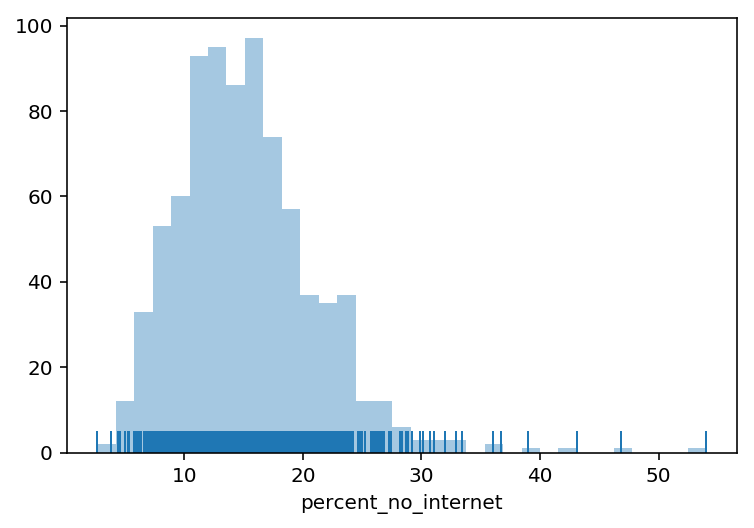

In [11]:
sns.distplot(df['percent_no_internet'], kde=False, rug=True)

In this graph, the x axis is the percentage of population in a county without internet access, and the y axis is the total number of counties in that range in the data. From the graph we can confidently deduce that the variable is normally distributed.

### 1) Education
Basic scatter matrices are listed below. This is followed by scatter plots comparing the variables of interest with overall internet usage. Outliers are highlighted in red, and the line of best fit helps visualize the overall relationship between the two variables. Actual analysis of values will similarly be analyzed.

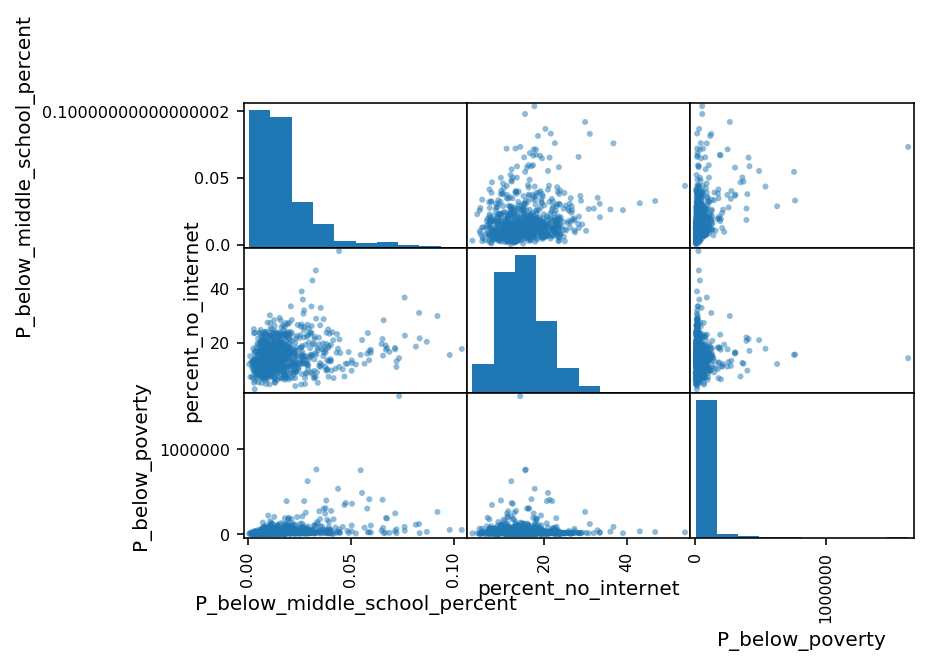

In [12]:
edu_middle = pd.plotting.scatter_matrix(df[['P_below_middle_school_percent', 'percent_no_internet', 'P_below_poverty']])

The matrix vaguely suggests that in counties with a larger percent of people who received below middle school education, the percent of people without internet is larger. There is a weak positive relationship between percent below middle school and percent no internet.

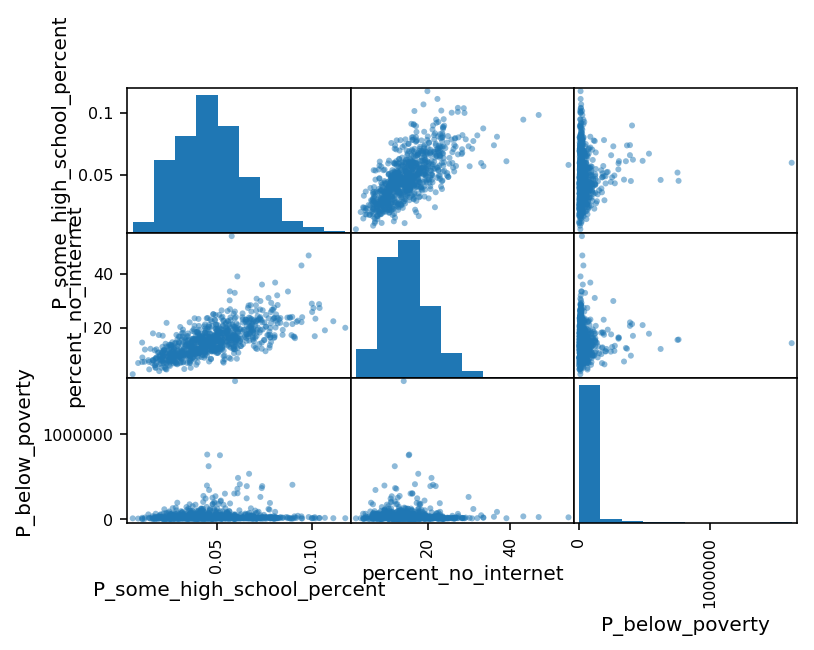

In [13]:
edu_high = pd.plotting.scatter_matrix(df[['P_some_high_school_percent', 'percent_no_internet', 'P_below_poverty']])

The matrix supports that in counties with a larger percent of people who received some high school education, the percent of people without internet is larger. There is a strong positive relationship between percent some high school and percent no internet.

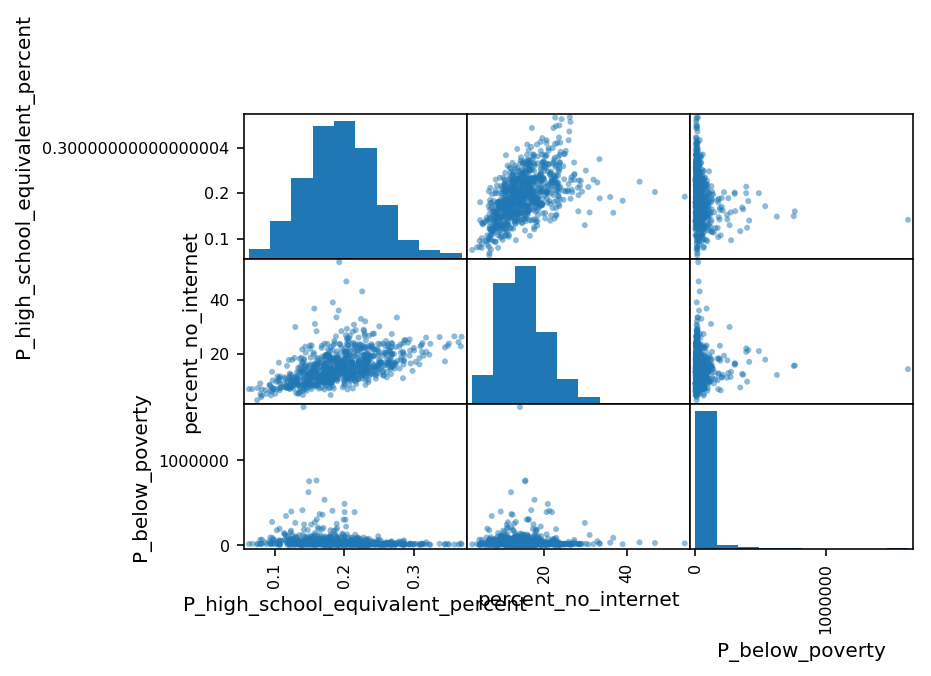

In [14]:
edu_highe = pd.plotting.scatter_matrix(df[['P_high_school_equivalent_percent', 'percent_no_internet', 'P_below_poverty']])

The matrix clearly suggests that in counties with a larger percent of people who received high school equivalent education, the percent of people without internet is larger. There is a strong positive relationship between percent high school and percent no internet.

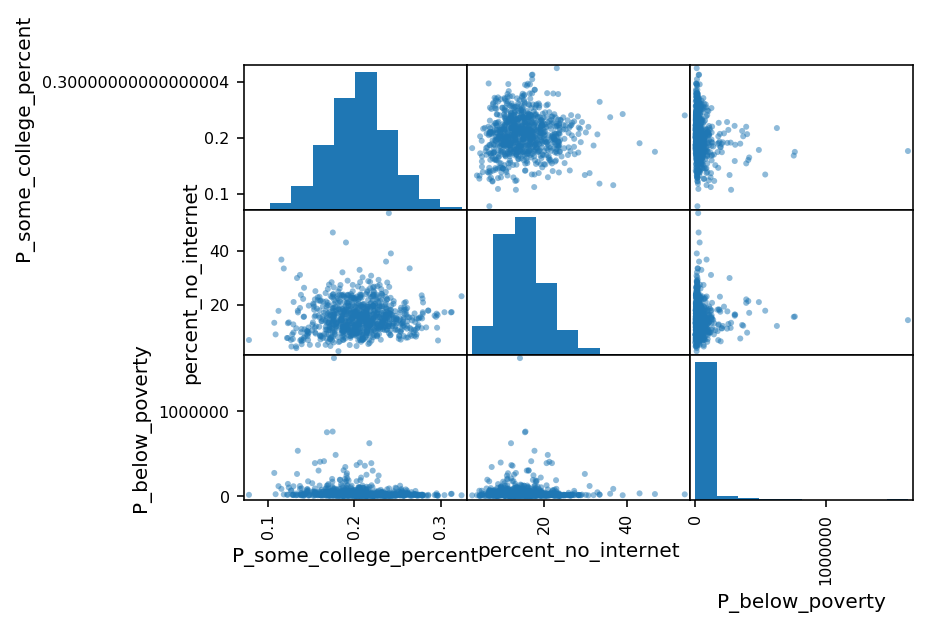

In [15]:
edu_college = pd.plotting.scatter_matrix(df[['P_some_college_percent', 'percent_no_internet', 'P_below_poverty']])

The matrix suggests that there is no obvious relationship between percent some college and percent no internet.

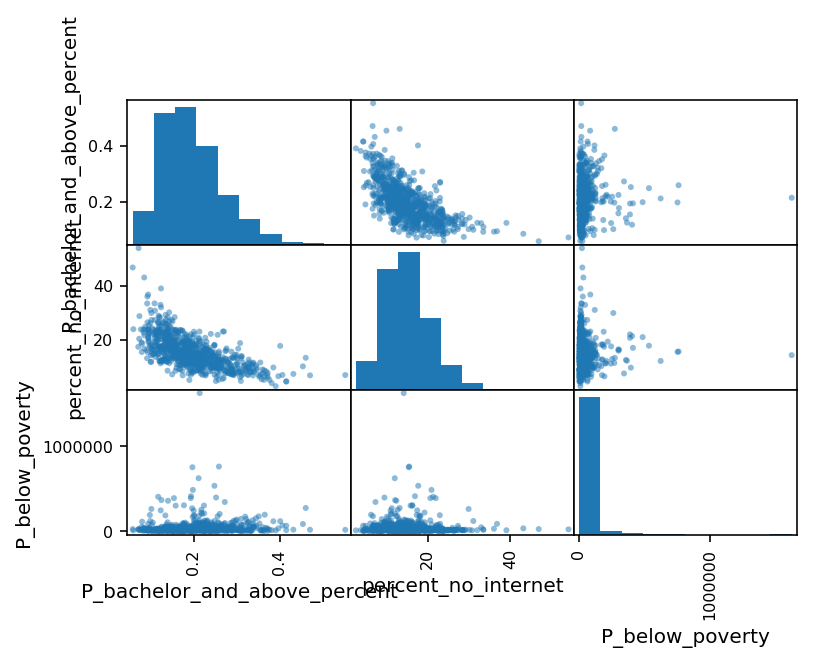

In [16]:
edu_bachelor = pd.plotting.scatter_matrix(df[['P_bachelor_and_above_percent', 'percent_no_internet', 'P_below_poverty']])

The matrix vaguely suggests that in counties with a larger percent of people who received bachelor and above education, the percent of people without internet is smaller. There is a negative relationship between percent bachelor and above and percent no internet. The relationship between poverty and education level is not evident in the matrieces.

From the graphs we can see that education level and internet usage are two related variables, and we will further explore their relationships below.

# Methods for More Advanced Graphs
Below are helper methods to detect and highlight outliers, as well as create the line of best fit. To further analyze the education variable, we also made a method to add two columns to the current dataframe by calculating the percentages of people below and above high school. 

In [17]:
#method to calculate the percentage of population above/below high school, and add it to df
def percentageEducated():
    #store percentages in list
    list_PercentAboveHS = []
    list_PercentBelowHS = []
    #used to calculate percentages
    sumTotal = 0
    sumBelowHS = 0
    
    #loop through all the rows
    for index,row in df.iterrows():
        
        sumTotal = (row['P_below_middle_school'] + row['P_some_high_school']
                        +row['P_high_school_equivalent']+row['P_some_college']
                            +row['P_bachelor_and_above'])
        sumBelowHS = (row['P_below_middle_school'] + row['P_some_high_school']
                        +row['P_high_school_equivalent'])
        list_PercentBelowHS.append(sumBelowHS/sumTotal)
        list_PercentAboveHS.append(1-(sumBelowHS/sumTotal))
    #add columns to dataset
    df['Percent_Population_Above_HS_Education'] = list_PercentAboveHS
    df['Percent_Population_Below_HS_Education'] = list_PercentBelowHS

In [18]:
#method to calculate the outliers of a given series
def findOutliers(sortMe):
    #store outliers
    list_Outliers = []
    #sort series
    storeSorted = sorted(sortMe)
    #calculate all three quartiles for calculation
    q1 = np.nanquantile(storeSorted,.25,None)
    q2 = np.nanquantile(storeSorted,.50,None)
    q3 = np.nanquantile(storeSorted,.75,None)
    #bounds to determine if outlier
    IQR = q3-q1
    lowerBound = q1 - 1.5*IQR
    upperBound = q3 + 1.5*IQR
   
    #loop through series, see if within bounds
    for element in storeSorted:
        
        if ((element < lowerBound) or (element > upperBound)):
            list_Outliers.append(element)

    return list_Outliers    

In [19]:
#method that calculates the slope for the line of best fit
def findBestFitSlope(seriesX, seriesY):
    #calculates mean
    meanX = seriesX.mean()
    meanY = seriesY.mean()
    #helper variables to obtain slope 
    sumTop = 0
    sumBottom = 0
    #return value
    slopeBestFit = 0
    #loop through series, follow equation of best line fit
    for index,value in df.iterrows():
        if (seriesX[index] >= 0 or seriesX[index] <= 0):
            sumTop += ((seriesX[index]-meanX)*(seriesY[index]-meanY))
            sumBottom += ((seriesX[index])-meanX)*((seriesX[index]-meanX)) 
    slopeBestFit = sumTop/sumBottom
    return slopeBestFit
    

In [20]:
#method that calculates the y intercept for the line of best fit
def findYIntercept(xBar, yBar, slope):
    #follows equation b=Ybar-m(Xbar) 
    yIntercept = yBar - slope*xBar
    return yIntercept
    

In [21]:
#method that populates a list of all the y coordinates
def listOfPointsBestFit(slope, seriesX, yIntercept):
    #store y coordinates
    listOfPoints = []
    localIndex = 0
    #loop through series, apply equation to all points in x series
    for element in seriesX:
        point = slope*seriesX[localIndex] + yIntercept
        listOfPoints.append(point)
        localIndex += 1

    return listOfPoints

### 1) Education (CONTINUED)

the slope is: -45.72576183329986
the y intercept is: 42.993469549312714


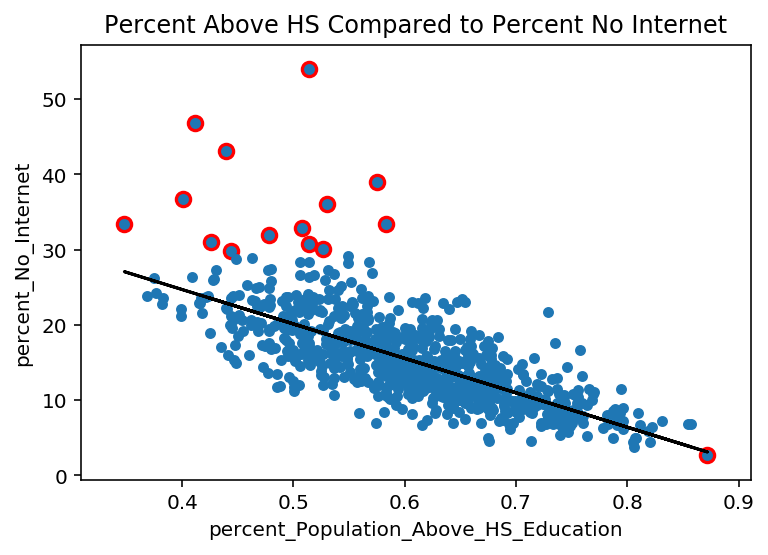

In [22]:
#add column
percentageEducated()

#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
aboveHSOutliers = findOutliers(df.Percent_Population_Above_HS_Education)

#store the outliers
noInternet = []
aboveHS = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['Percent_Population_Above_HS_Education'][index] in aboveHSOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        aboveHS.append(df['Percent_Population_Above_HS_Education'][index])
#graph outliers in red
plt.scatter(aboveHS, noInternet, s=60,c="red")

#create scatterplot relating education levels to internet usage levels
plt.scatter(df.Percent_Population_Above_HS_Education, df.percent_no_internet, s=20)

#line of best fit
m = findBestFitSlope(df['Percent_Population_Above_HS_Education'], df['percent_no_internet'])
xBar = df['Percent_Population_Above_HS_Education'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['Percent_Population_Above_HS_Education'], yIntercept)
plt.plot(df['Percent_Population_Above_HS_Education'], listPoints, color='k')
print("the slope is: " + str(m))
print("the y intercept is: " + str(yIntercept))

#label graph
plt.xlabel('percent_Population_Above_HS_Education')
plt.ylabel('percent_No_Internet')
plt.title("Percent Above HS Compared to Percent No Internet")
f1 = plt.gcf()

the slope is: 45.72576183329987
the y intercept is: -2.732292283987155


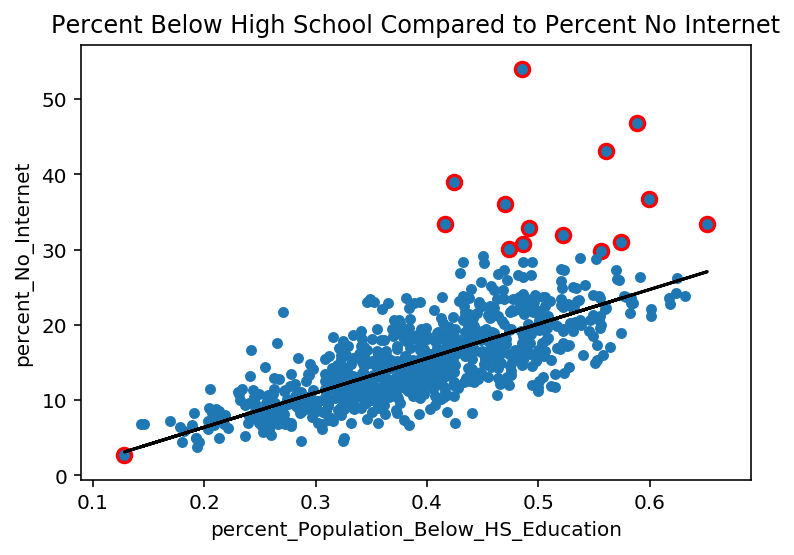

In [23]:
#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
belowHSOutliers = findOutliers(df.Percent_Population_Below_HS_Education)

#store the outliers
noInternet = []
belowHS = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['Percent_Population_Below_HS_Education'][index] in belowHSOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        belowHS.append(df['Percent_Population_Below_HS_Education'][index])
#graph outliers in red
plt.scatter(belowHS, noInternet, s=60,c="red")

#create scatterplot relating education levels to internet usage levels
plt.scatter(df['Percent_Population_Below_HS_Education'], df['percent_no_internet'], s=20)

#line of best fit

m = findBestFitSlope(df['Percent_Population_Below_HS_Education'], df['percent_no_internet'])
xBar = df['Percent_Population_Below_HS_Education'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['Percent_Population_Below_HS_Education'], yIntercept)
plt.plot(df['Percent_Population_Below_HS_Education'], listPoints, color='k')
print("the slope is: " + str(m))
print("the y intercept is: " + str(yIntercept))

#label graph
plt.xlabel('percent_Population_Below_HS_Education')
plt.ylabel('percent_No_Internet')
plt.title("Percent Below High School Compared to Percent No Internet")
f2 = plt.gcf()

From the graphs we conclude that counties with more educated residents presumably have a smaller percent of population without internet, and counties with less educated residents probably have a larger percent of population without internet.

### 2) Poverty level

the slope is: 0.8051949316743839
the y intercept is: 4.602271351287223


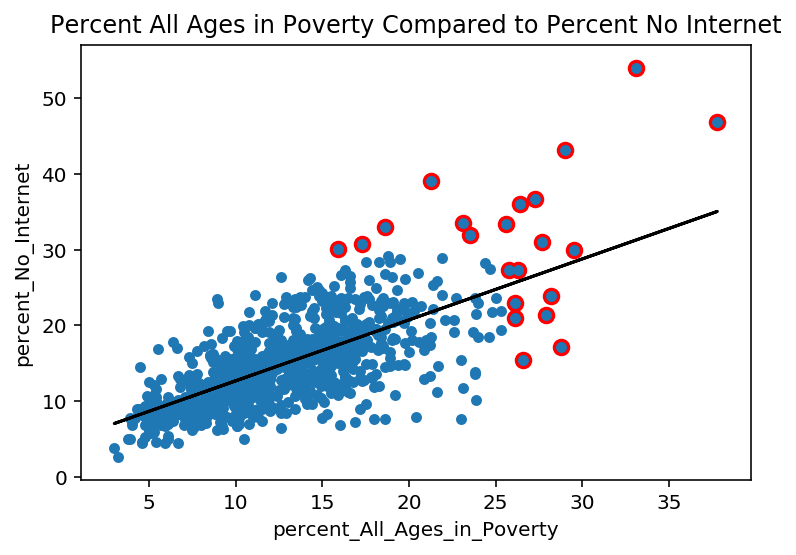

In [24]:
#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
allAgesPovertyOutliers = findOutliers(df.AllAgesinPovertyPercent)

#store the outliers
noInternet = []
allAgePov = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['AllAgesinPovertyPercent'][index] in allAgesPovertyOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        allAgePov.append(df['AllAgesinPovertyPercent'][index])
#graph outliers in red
plt.scatter(allAgePov, noInternet, s=60,c="red")

#create scatterplot relating poverty levels to internet usage levels
plt.scatter(df['AllAgesinPovertyPercent'],df['percent_no_internet'],s=20)

#line of best fit
m = findBestFitSlope(df['AllAgesinPovertyPercent'], df['percent_no_internet'])
xBar = df['AllAgesinPovertyPercent'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['AllAgesinPovertyPercent'], yIntercept)
plt.plot(df['AllAgesinPovertyPercent'], listPoints, color='k')
print("the slope is: " + str(m))
print("the y intercept is: " + str(yIntercept))

#label graph
plt.xlabel('percent_All_Ages_in_Poverty')
plt.ylabel('percent_No_Internet')
plt.title("Percent All Ages in Poverty Compared to Percent No Internet")
f3 = plt.gcf()


the slope is: 0.5851465508406951
the y intercept is: 4.851990524572868


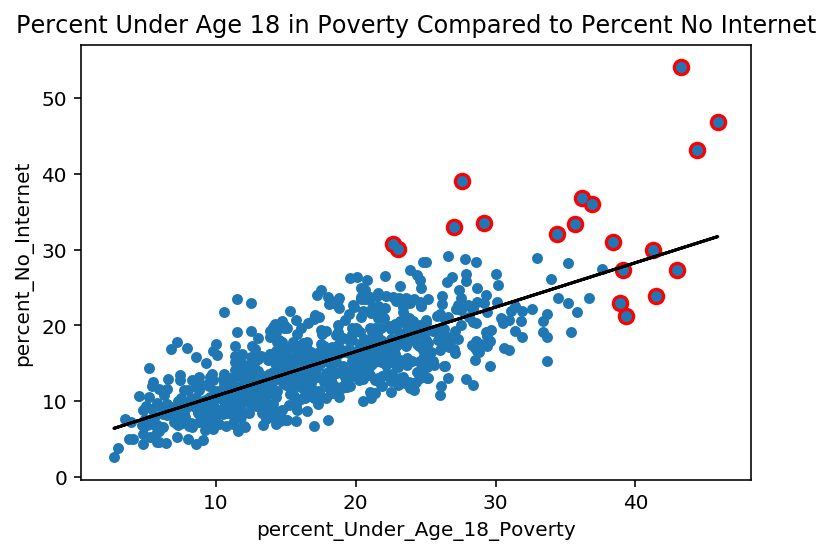

In [25]:
#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
underAge18PovertyOutliers = findOutliers(df.UnderAge18inPovertyPercent)

#store the outliers
noInternet = []
underAgePov = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['UnderAge18inPovertyPercent'][index] in underAge18PovertyOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        underAgePov.append(df['UnderAge18inPovertyPercent'][index])
#graph outliers in red
plt.scatter(underAgePov, noInternet, s=60,c="red")

#create scatterplot relating poverty levels to internet usage levels
plt.scatter(df['UnderAge18inPovertyPercent'],df['percent_no_internet'], s=20)


#line of best fit
m = findBestFitSlope(df['UnderAge18inPovertyPercent'], df['percent_no_internet'])
xBar = df['UnderAge18inPovertyPercent'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['UnderAge18inPovertyPercent'], yIntercept)
plt.plot(df['UnderAge18inPovertyPercent'], listPoints, color='k')
print("the slope is: " + str(m))
print("the y intercept is: " + str(yIntercept))

#label graph
plt.xlabel('percent_Under_Age_18_Poverty')
plt.ylabel('percent_No_Internet')
plt.title("Percent Under Age 18 in Poverty Compared to Percent No Internet")
f4 = plt.gcf()


From the graphs we conclude that regardless of the age group, counties with wealthier residents presumably have a smaller percent of population without internet, and counties with poorer residents probably have a larger percent of population without internet. There is a positive relationship between poverty percent and percent no internet.

### 3) Income level

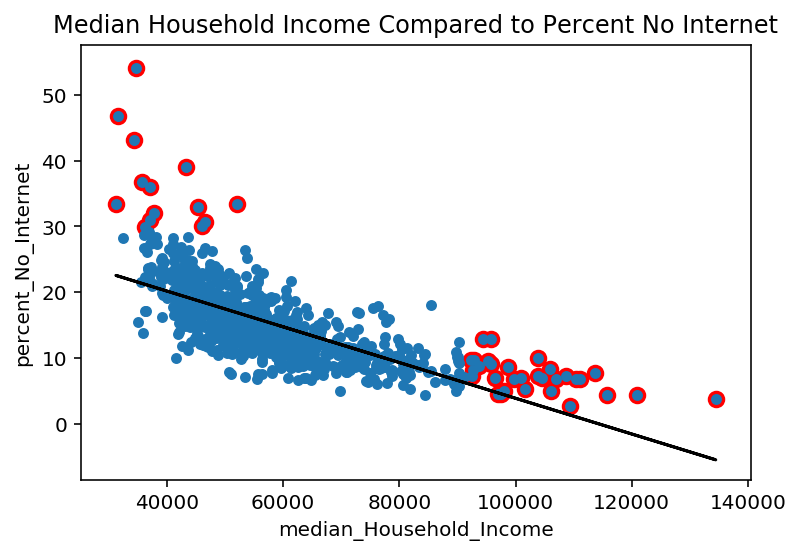

In [26]:
#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
medianIncomeOutliers = findOutliers(df.median_household_income)

#store the outliers
noInternet = []
medianIncome = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['median_household_income'][index] in medianIncomeOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        medianIncome.append(df['median_household_income'][index])
        
#graph outliers in red
plt.scatter(medianIncome, noInternet, s=60,c="red")

#create scatterplot relating average house hold income to internet usage levels
plt.scatter(df['median_household_income'],df['percent_no_internet'], s=20)

#line of best fit
m = findBestFitSlope(df['median_household_income'], df['percent_no_internet'])
xBar = df['median_household_income'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['median_household_income'], yIntercept)
plt.plot(df['median_household_income'], listPoints, color='k')

#label graph
plt.xlabel('median_Household_Income')
plt.ylabel('percent_No_Internet')
plt.title("Median Household Income Compared to Percent No Internet")
f5 = plt.gcf()


The graph further affirm our previous assumption that economic factors and internet usage are linked. There is a negative relationship between median income and percent no internet.

### 4) Income Inequality level

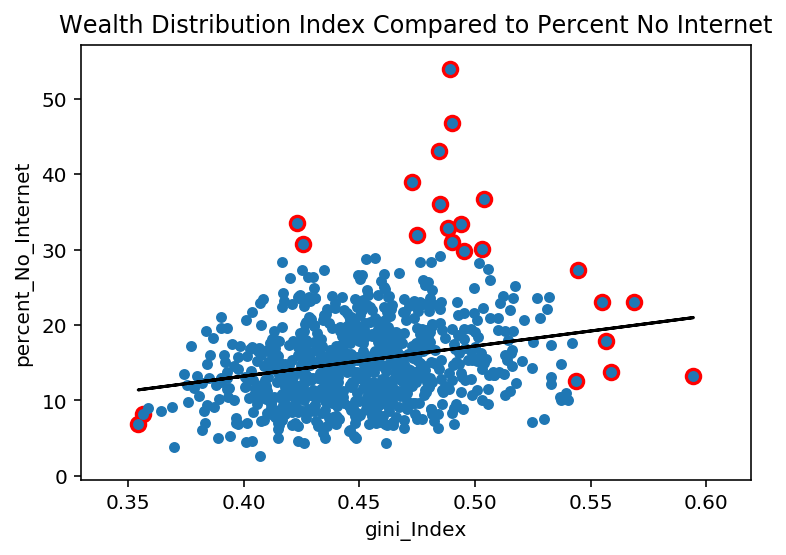

In [27]:
#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
giniOutliers = findOutliers(df.gini_index)

#store the outliers
noInternet = []
giniInd = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['gini_index'][index] in giniOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        giniInd.append(df['gini_index'][index])
        
#graph outliers in red
plt.scatter(giniInd, noInternet, s=60,c="red")

#create scatterplot relating gini index and percentage no internet
plt.scatter(df['gini_index'], df['percent_no_internet'], s = 20)

#line of best fit
m = findBestFitSlope(df['gini_index'], df['percent_no_internet'])
xBar = df['gini_index'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['gini_index'], yIntercept)
plt.plot(df['gini_index'], listPoints, color='k')

#label graph
plt.xlabel('gini_Index')
plt.ylabel('percent_No_Internet')
plt.title("Wealth Distribution Index Compared to Percent No Internet")
f6 = plt.gcf()

The graph shows that there is a weak positive relationship between the gini index and percent no internet, which means that counties with larger wealthy disparities might have more people without access to the internet.

### 5) Age

Text(0.5, 1.0, 'Age Compared to Percent No internet')

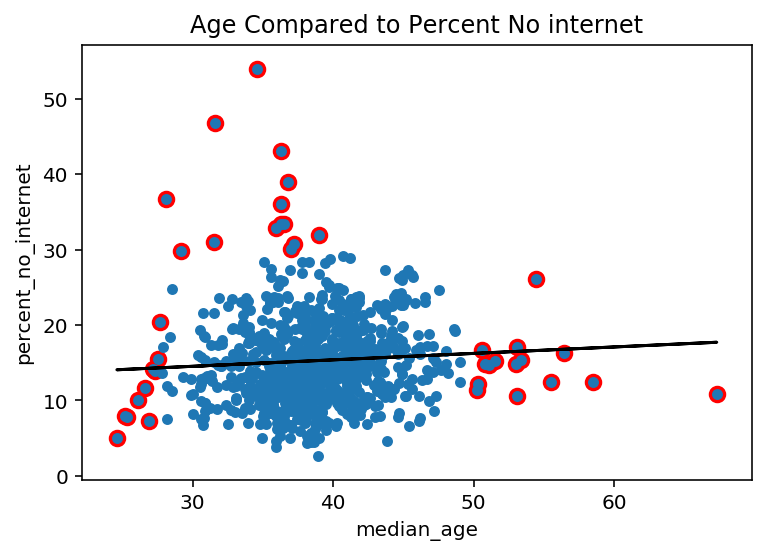

In [28]:
#obtain outliers for each series object
noInternetOutliers = findOutliers(df.percent_no_internet)
ageOutliers = findOutliers(df.median_age)

#store the outliers
noInternet = []
medianAge = []

#append the pair of outliers
for index,value in df.iterrows():
    if ((df['percent_no_internet'][index] in noInternetOutliers) or 
            (df['median_age'][index] in ageOutliers)):
        noInternet.append(df['percent_no_internet'][index])
        medianAge.append(df['median_age'][index])
        
#graph outliers in red
plt.scatter(medianAge, noInternet, s=60,c="red")

#create scatterplot related age and percentage no internet
plt.scatter(df['median_age'], df['percent_no_internet'],s=20)

#line of best fit
m = findBestFitSlope(df['median_age'], df['percent_no_internet'])
xBar = df['median_age'].mean()
yBar = df['percent_no_internet'].mean()
yIntercept = findYIntercept(xBar, yBar, m)
listPoints = listOfPointsBestFit(m,df['median_age'], yIntercept)
plt.plot(df['median_age'], listPoints, color='k')

#label graph
plt.xlabel('median_age')
plt.ylabel('percent_no_internet')
plt.title("Age Compared to Percent No internet")

The graph shows that there is a weak positive relationship between the median age of a county and percent no internet, which means that counties with more elderly people might have more people without access to the internet.

# Geospatial Analysis

In order to draw better insight on the correlation between Internet usage and social-economic status, we group counties into states and create a geographical US map using the third dataset 21_statesbasic. 

In [29]:
# groupByState is a dictionary that maps each state abbreviation to its total population
groupByState = dict(df.groupby(df['countyState'].str[-3:-1])['P_total'].sum())
#groupByState

In [30]:
# 'New_group_by_state.csv' is a new dataset that is combined from df and states.shp file from 21_statesbasic
# The social-economic variables are now summarized in state level
usa=gpd.read_file('New_group_by_state.csv')

In [31]:
usa.head()

,field_1,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,...,sum(P_some_college),sum(P_bachelor_and_above),avg(P_below_poverty),avg(median_age),avg(gini_index),avg(median_household_income),avg(percent_no_internet),Percentage_of_Population,Percentage_of_Education,geometry
0,0,0,0,0,0,0,0,0,0,0,...,316915.0,316571.0,32391.0,40.875,0.444625,69966.0,13.4544223445584,0.005229495935374612,0.0035786977289648117,None
1,1,1,1,1,1,1,1,1,1,1,...,1546468.0,1658313.0,37939.7894736842,38.978947368421004,0.433231578947368,59602.052631578896,11.661797146587901,0.024747621509993805,0.018560753176736323,None
2,2,2,2,2,2,2,2,2,2,2,...,137904.0,150859.0,12250.5,38.5833333333333,0.4714166666666671,54076.8333333333,13.787714737713001,0.0022924289206015685,0.0010855308959454605,None
3,3,3,3,3,3,3,3,3,3,3,...,200023.0,216792.0,18164.6666666667,43.383333333333304,0.4416833333333329,52368.0,15.101468142476199,0.0034487292363902526,0.00196443123105402,None
4,4,4,4,4,4,4,4,4,4,4,...,89781.0,92424.0,10666.0,32.375,0.43875,59094.75,10.552045964613,0.0015047474030258357,0.0006513387607687284,None


In [32]:
usa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 34 columns):
field_1                           51 non-null object
Unnamed: 0                        51 non-null object
Unnamed: 0.1                      51 non-null object
Unnamed: 0.1.1                    51 non-null object
Unnamed: 0.1.1.1                  51 non-null object
Unnamed: 0.1.1.1.1                51 non-null object
Unnamed: 0.1.1.1.1.1              51 non-null object
Unnamed: 0.1.1.1.1.1.1            51 non-null object
Unnamed: 0.1.1.1.1.1.1.1          51 non-null object
Unnamed: 0.1.1.1.1.1.1.1.1        51 non-null object
Unnamed: 0.1.1.1.1.1.1.1.1.1      51 non-null object
Unnamed: 0.1.1.1.1.1.1.1.1.1.1    51 non-null object
X                                 51 non-null object
Y                                 51 non-null object
STATE_NAME                        51 non-null object
DRAWSEQ                           51 non-null object
STATE_FIPS                        51 non-

In addition, we want to explore the correlation between population density, low education level and percent no Internet usage.

We merge two new columns:
1. Percentage_of_Population: percentage of population in each state out of the sum of population in the United States.
2. Percentage_of_Education: percentage of population with low education level in each state out of the sum of low eduation level population in the United States. Here we define low education level as population who went to high school without diploma or evern shorter education experiences.

In [33]:
df_new = pd.read_csv("New_group_by_state.csv")
sum = df_new['sum(P_total)'].sum()
sum_middle= df_new['sum(P_below_middle_school)'].sum()
sum_high=df_new['sum(P_some_high_school)'].sum()
sum_hig_add_middle=sum_middle+sum_high
df_new['Percentage_of_Population'] = df_new['sum(P_total)']/sum
df_new['Percentage_of_Education'] = (df_new['sum(P_below_middle_school)']+df_new['sum(P_some_high_school)'])/sum_hig_add_middle


In [34]:
df_new.to_csv("New_group_by_state.csv")

In [35]:
usa=gpd.read_file('New_group_by_state.csv')

In [36]:
usa.head(n=51)

,field_1,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,...,sum(P_some_college),sum(P_bachelor_and_above),avg(P_below_poverty),avg(median_age),avg(gini_index),avg(median_household_income),avg(percent_no_internet),Percentage_of_Population,Percentage_of_Education,geometry
0,0,0,0,0,0,0,0,0,0,0,...,316915.0,316571.0,32391.0,40.875,0.444625,69966.0,13.4544223445584,0.005229495935374612,0.0035786977289648117,None
1,1,1,1,1,1,1,1,1,1,1,...,1546468.0,1658313.0,37939.7894736842,38.978947368421004,0.43323157894736797,59602.052631578896,11.661797146587901,0.024747621509993805,0.018560753176736323,None
2,2,2,2,2,2,2,2,2,2,2,...,137904.0,150859.0,12250.5,38.5833333333333,0.4714166666666671,54076.8333333333,13.787714737713001,0.0022924289206015685,0.0010855308959454605,None
3,3,3,3,3,3,3,3,3,3,3,...,200023.0,216792.0,18164.6666666667,43.383333333333304,0.4416833333333329,52368.0,15.101468142476199,0.0034487292363902526,0.00196443123105402,None
4,4,4,4,4,4,4,4,4,4,4,...,89781.0,92424.0,10666.0,32.375,0.43875,59094.75,10.552045964613,0.0015047474030258357,0.0006513387607687284,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,46,46,46,46,46,46,46,46,46,...,329774.0,307358.0,22897.8181818182,36.8454545454545,0.4532454545454551,48644.0909090909,18.7660478871892,0.006125215086817287,0.005505665479328804,None
47,47,47,47,47,47,47,47,47,47,47,...,626127.0,600529.0,37718.2352941177,36.2764705882353,0.48022352941176505,48015.7058823529,20.4443446182947,0.012432828568543343,0.014025194671065078,None
48,48,48,48,48,48,48,48,48,48,48,...,4276385.0,4152102.0,69643.9268292683,44.9146341463415,0.463056097560976,51714.6341463415,14.0029202941301,0.07311037122625727,0.0780238413344239,None
49,49,49,49,49,49,49,49,49,49,49,...,1875909.0,1720173.0,42416.7586206897,39.5344827586207,0.447513793103448,54352.5517241379,15.5062092872163,0.031007156029787885,0.02385731075305034,None


In [37]:
# There are some unwanted columns so we wrote this block of try and except block to clean the unwanted columns if they exist.
try:
    usa = usa.drop(labels=['geometry'], axis=1)
    usa = usa.drop(labels=['field_1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1'], axis=1)
    usa = usa.drop(labels=['Percentage_of_Education_below_high_school'], axis=1)
    
except:
    pass

In [38]:
# These polygons in geometry column are in tuple of longtitude/latitude points that make up the border of each US state
shapes = gpd.read_file('states.shp')
shapes = shapes[['STATE_NAME', 'geometry']]
new_df = pd.merge(usa, shapes, on='STATE_NAME', how='outer')
new_df.head()

,X,Y,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,Statename,sum(P_total),sum(P_below_middle_school),...,sum(P_some_college),sum(P_bachelor_and_above),avg(P_below_poverty),avg(median_age),avg(gini_index),avg(median_household_income),avg(percent_no_internet),Percentage_of_Population,Percentage_of_Education,geometry
0,-155.41377145564698,19.5841066218165,Hawaii,1,15,Pacific,HI,HI,1428462,27209.0,...,316915.0,316571.0,32391.0,40.875,0.444625,69966.0,13.4544223445584,0.005229495935374612,0.0035786977289648117,(POLYGON ((-160.0738033454681 22.0041773479577...
1,-119.72177349929399,47.27282067548101,Washington,2,53,Pacific,WA,WA,6759932,125685.0,...,1546468.0,1658313.0,37939.7894736842,38.978947368421004,0.43323157894736797,59602.052631578896,11.661797146587901,0.024747621509993805,0.018560753176736323,(POLYGON ((-122.4020153103835 48.2252163723779...
2,-109.341420388743,46.679014781729,Montana,3,30,Mountain,MT,MT,626188,2471.0,...,137904.0,150859.0,12250.5,38.5833333333333,0.4714166666666671,54076.8333333333,13.787714737713001,0.0022924289206015685,0.0010855308959454605,POLYGON ((-111.4754253002074 44.70216236909688...
3,-69.1627558669746,45.2517924837451,Maine,4,23,New England,ME,ME,942037,7436.0,...,200023.0,216792.0,18164.6666666667,43.383333333333304,0.4416833333333329,52368.0,15.101468142476199,0.0034487292363902526,0.00196443123105402,(POLYGON ((-69.77727626137293 44.0741483685119...
4,-100.45330405002399,47.4810782039369,North Dakota,5,38,West North Central,ND,ND,411029,1837.0,...,89781.0,92424.0,10666.0,32.375,0.43875,59094.75,10.552045964613,0.0015047474030258357,0.0006513387607687284,POLYGON ((-98.73043728833767 45.93827137024809...


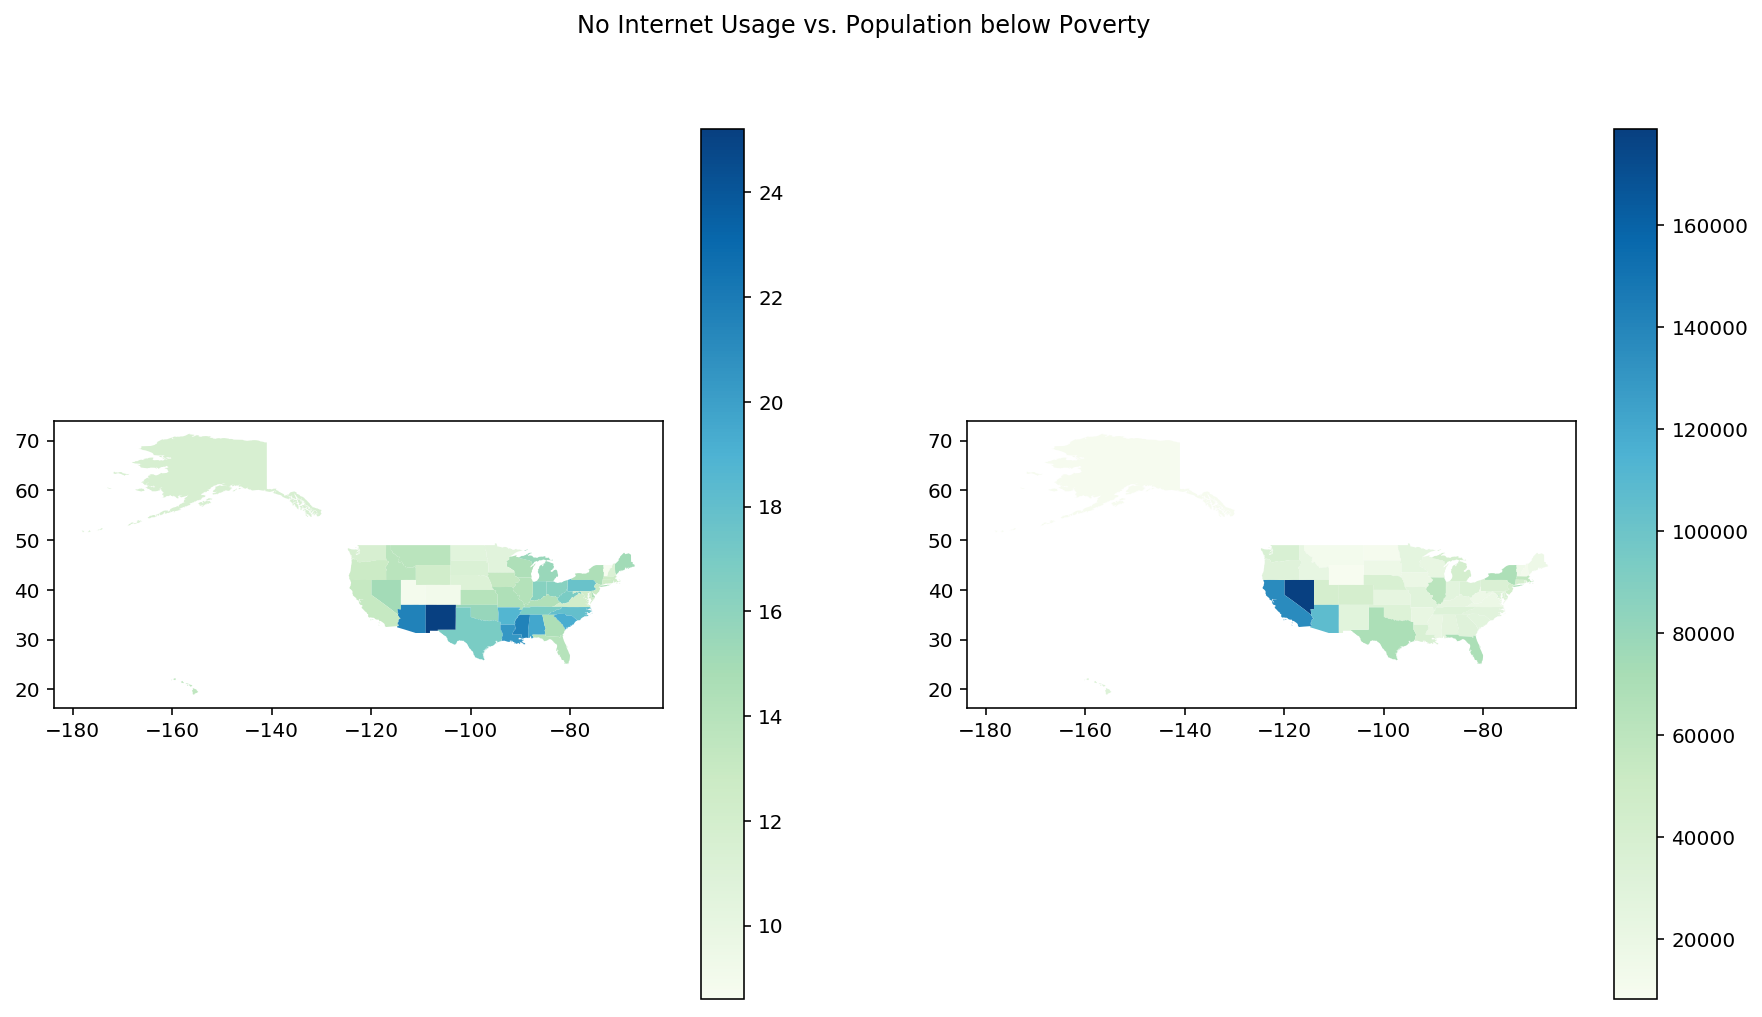

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2)

# This choropleth map plots no Internet usage percentage with green/blue color scale
new_df['avg(percent_no_internet)'] =  pd.to_numeric(new_df['avg(percent_no_internet)'])
new_df.plot(column='avg(percent_no_internet)',ax=ax[0], cmap='GnBu', legend=True);


# This choropleth map plots population below poverty with green/blue color scale
new_df['avg(P_below_poverty)'] =  pd.to_numeric(new_df['avg(P_below_poverty)'])
new_df.plot(column='avg(P_below_poverty)',ax=ax[1], cmap='GnBu',legend=True);

fig.suptitle("No Internet Usage vs. Population below Poverty")
fig.set_size_inches(15, 8)
plt.show()


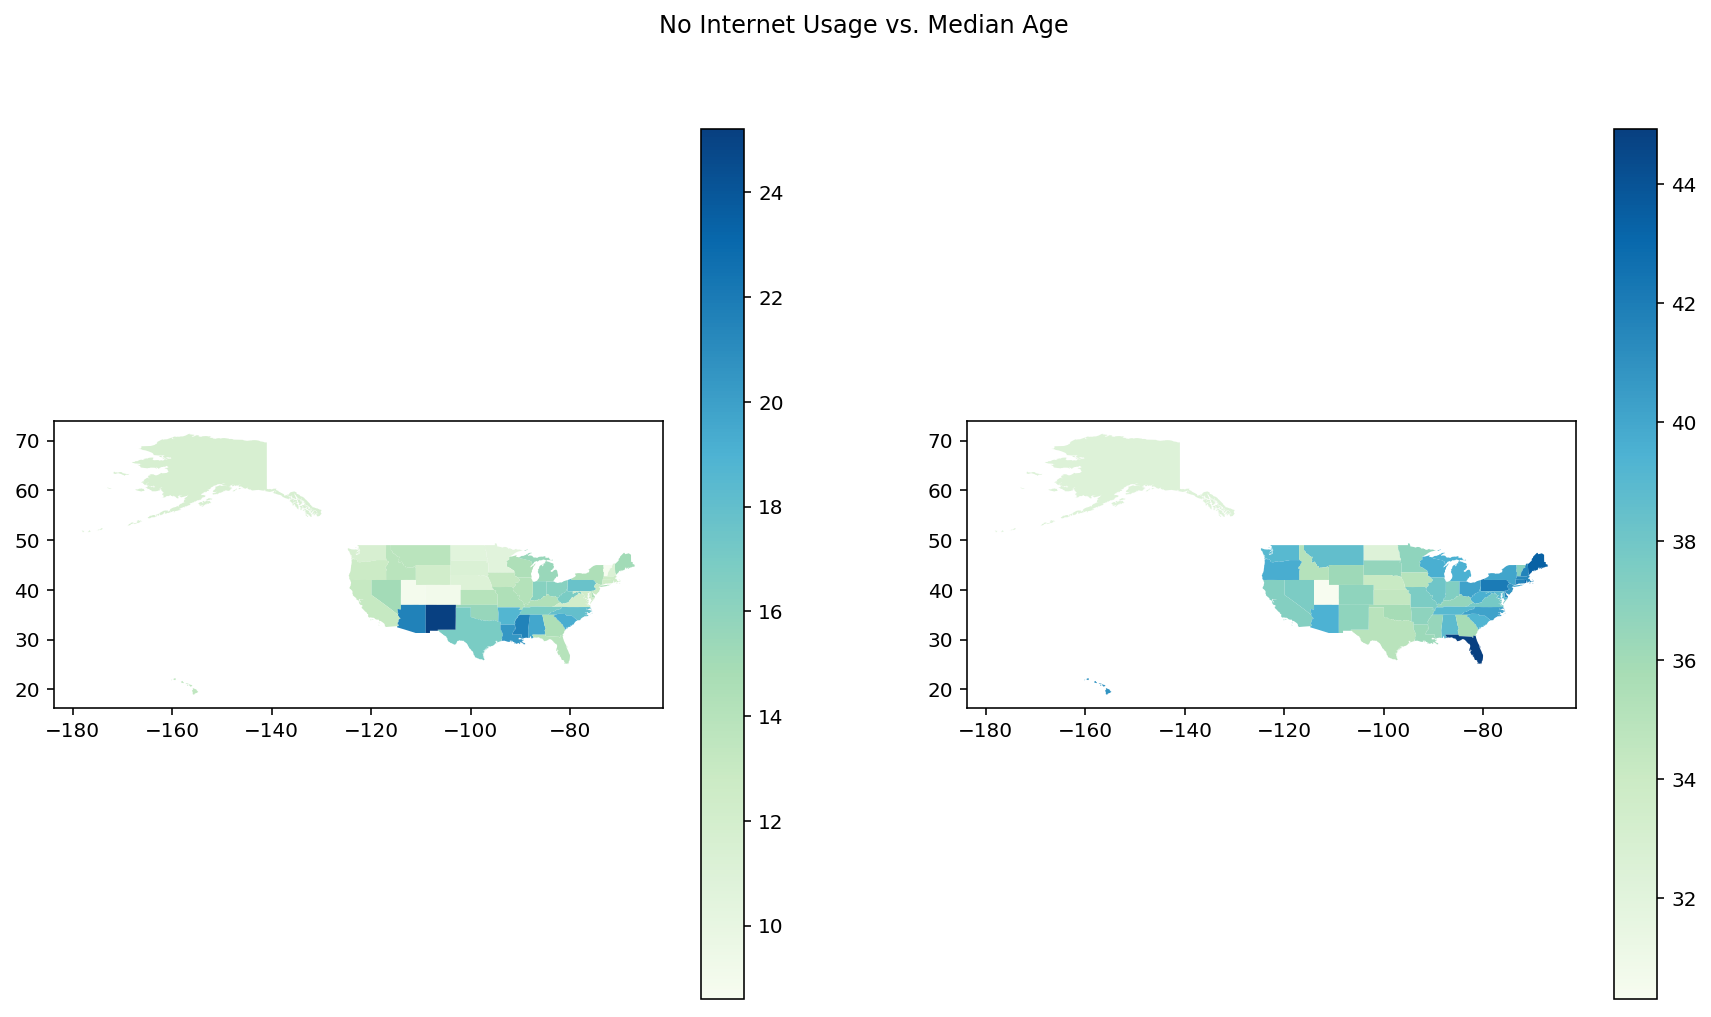

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2)


# This choropleth map plots no Internet usage percentage with green/blue color scale
new_df['avg(percent_no_internet)'] =  pd.to_numeric(new_df['avg(percent_no_internet)'])
new_df.plot(column='avg(percent_no_internet)',ax=ax[0], cmap='GnBu', legend=True);

# This choropleth map plots median age distribution with green/blue color scale
new_df['avg(median_age)'] =  pd.to_numeric(new_df['avg(median_age)'])
new_df.plot(column='avg(median_age)',ax=ax[1], cmap='GnBu',legend=True);

fig.suptitle("No Internet Usage vs. Median Age")
fig.set_size_inches(15, 8)
plt.show()

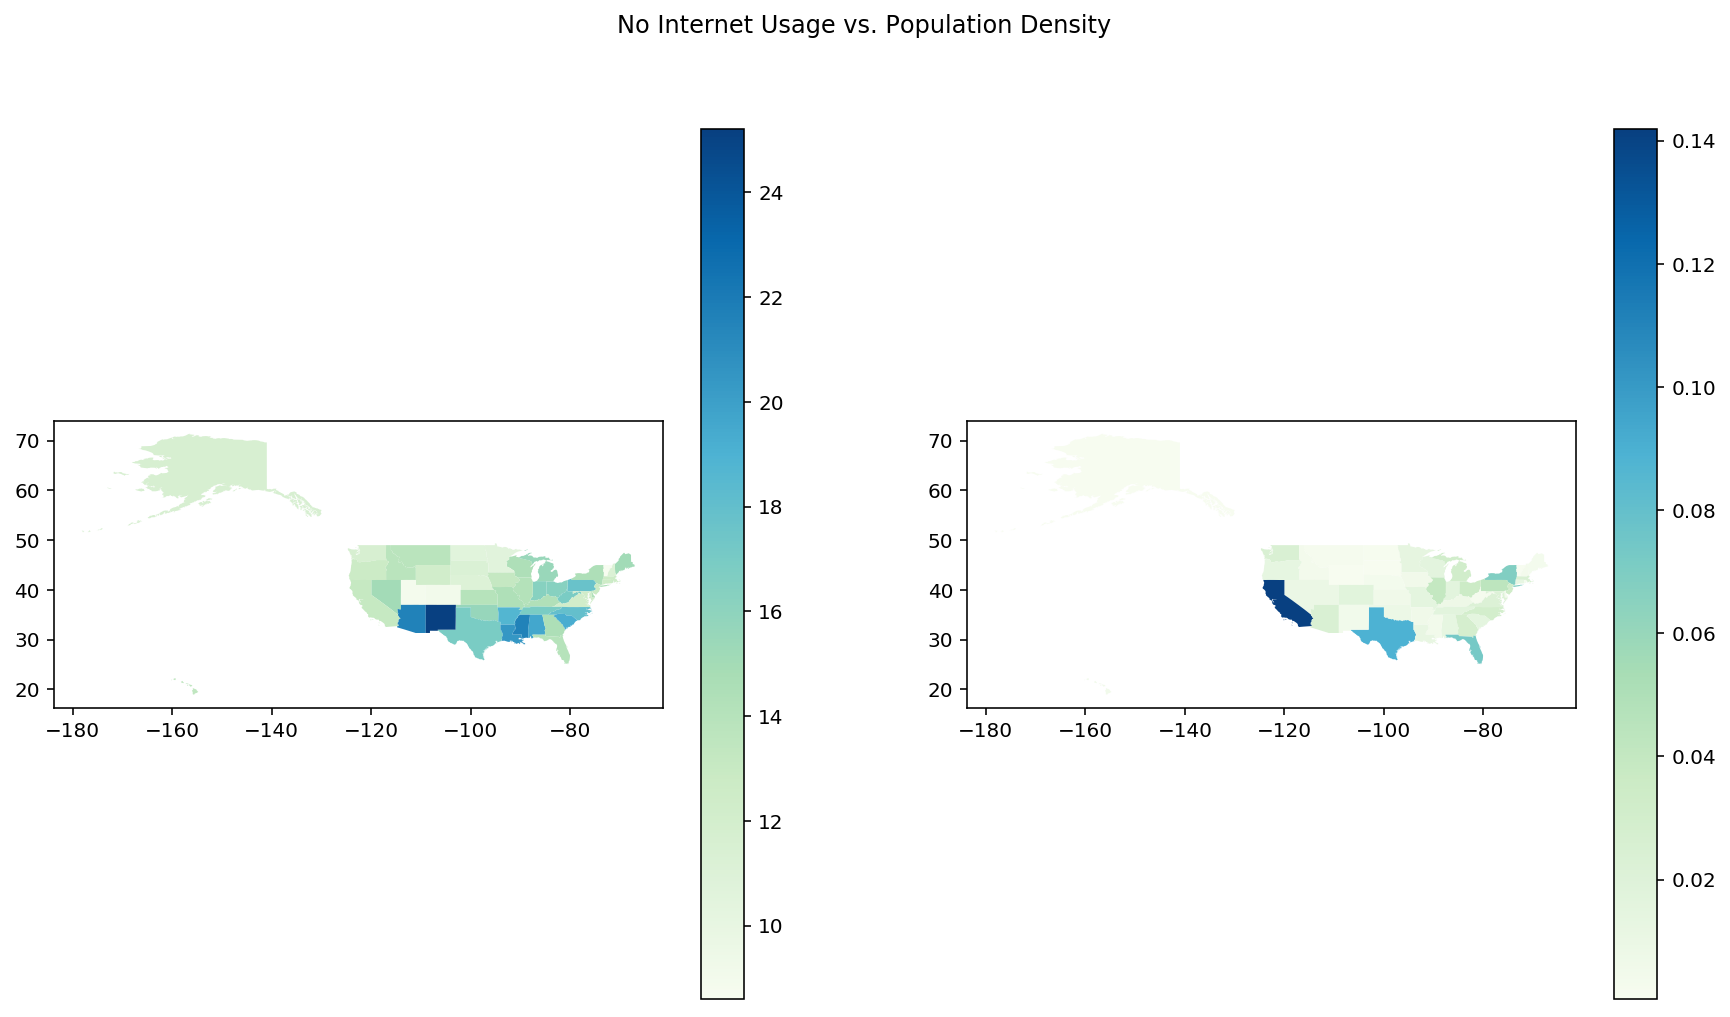

In [41]:

fig, ax = plt.subplots(nrows=1, ncols=2)

# This choropleth map plots no Internet usage percentage with green/blue color scale
new_df['avg(percent_no_internet)'] =  pd.to_numeric(new_df['avg(percent_no_internet)'])
new_df.plot(column='avg(percent_no_internet)',ax=ax[0], cmap='GnBu', legend=True);

# This choropleth map plots population density with green/blue color scale
new_df['Percentage_of_Population'] =  pd.to_numeric(new_df['Percentage_of_Population'])
new_df.plot(column='Percentage_of_Population',ax=ax[1], cmap='GnBu',legend=True);

fig.suptitle("No Internet Usage vs. Population Density")
fig.set_size_inches(15, 8)
plt.show()

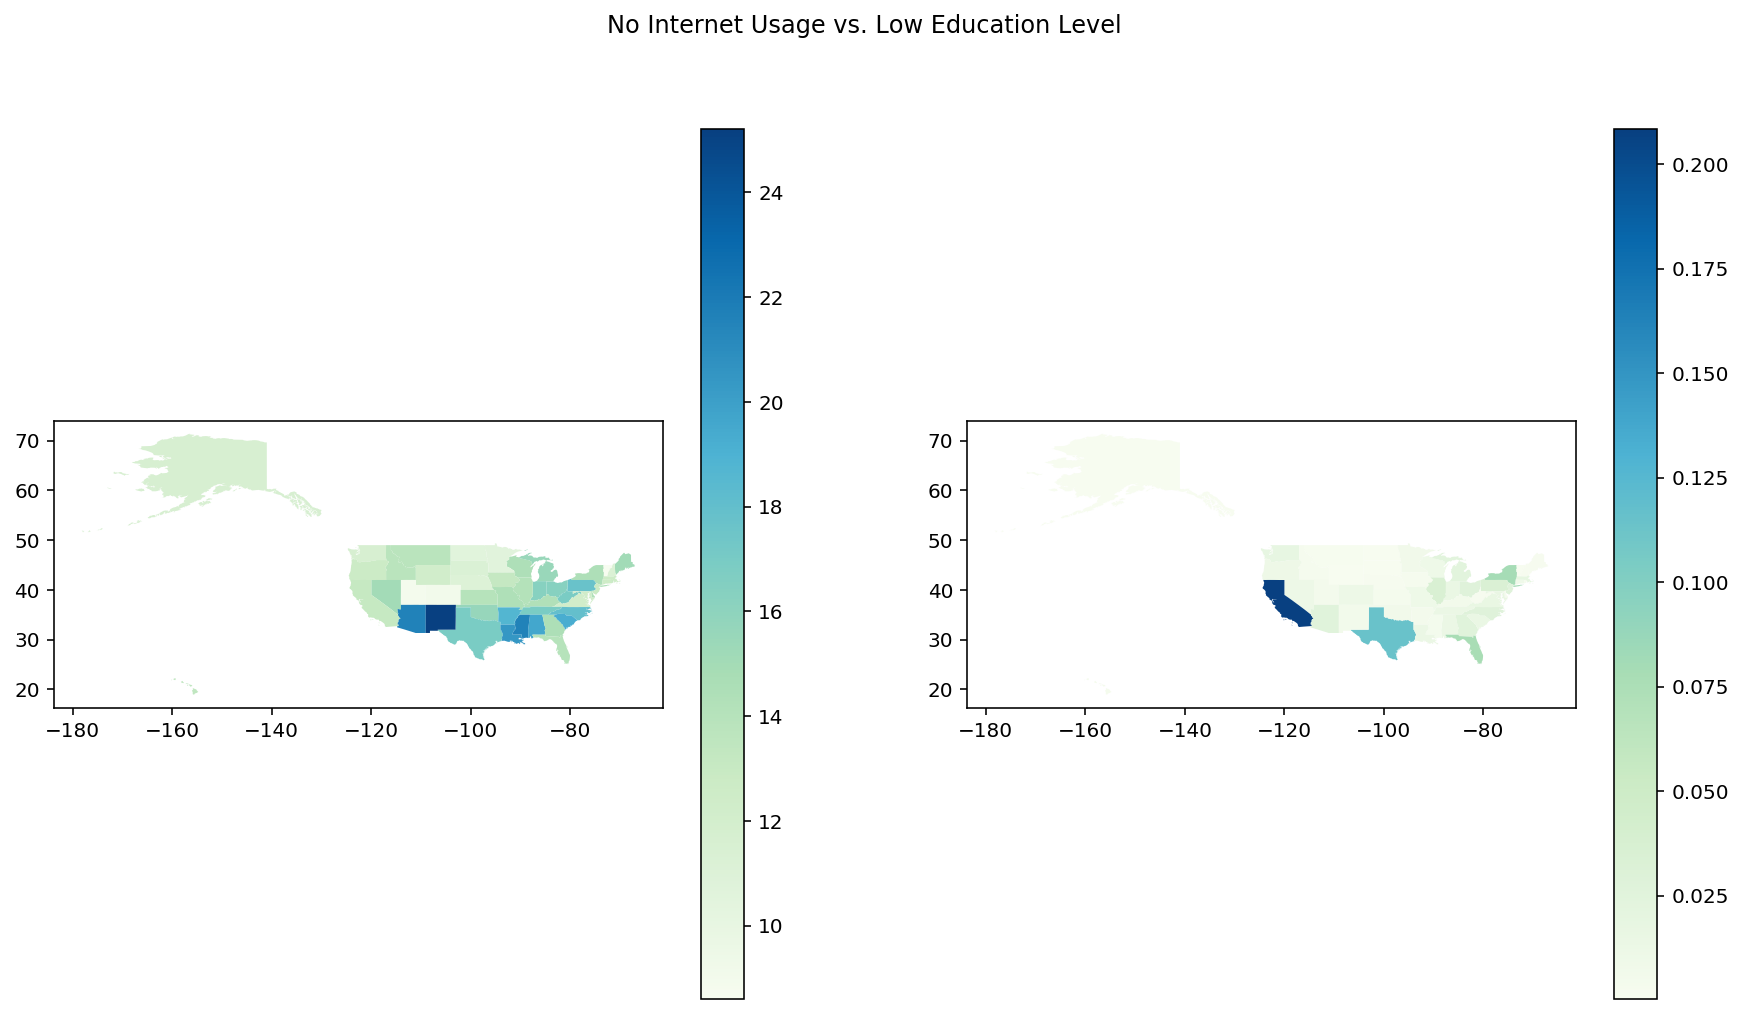

In [42]:

fig, ax = plt.subplots(nrows=1, ncols=2)
# This choropleth map plots no Internet usage percentage with green/blue color scale
new_df['avg(percent_no_internet)'] =  pd.to_numeric(new_df['avg(percent_no_internet)'])
new_df.plot(column='avg(percent_no_internet)',ax=ax[0], cmap='GnBu', legend=True);

# This choropleth map plots low educational level with green/blue color scale
new_df['Percentage_of_Education'] =  pd.to_numeric(new_df['Percentage_of_Education'])
new_df.plot(column='Percentage_of_Education',ax=ax[1], cmap='GnBu',legend=True);

fig.suptitle("No Internet Usage vs. Low Education Level")
fig.set_size_inches(15, 8)
plt.show()

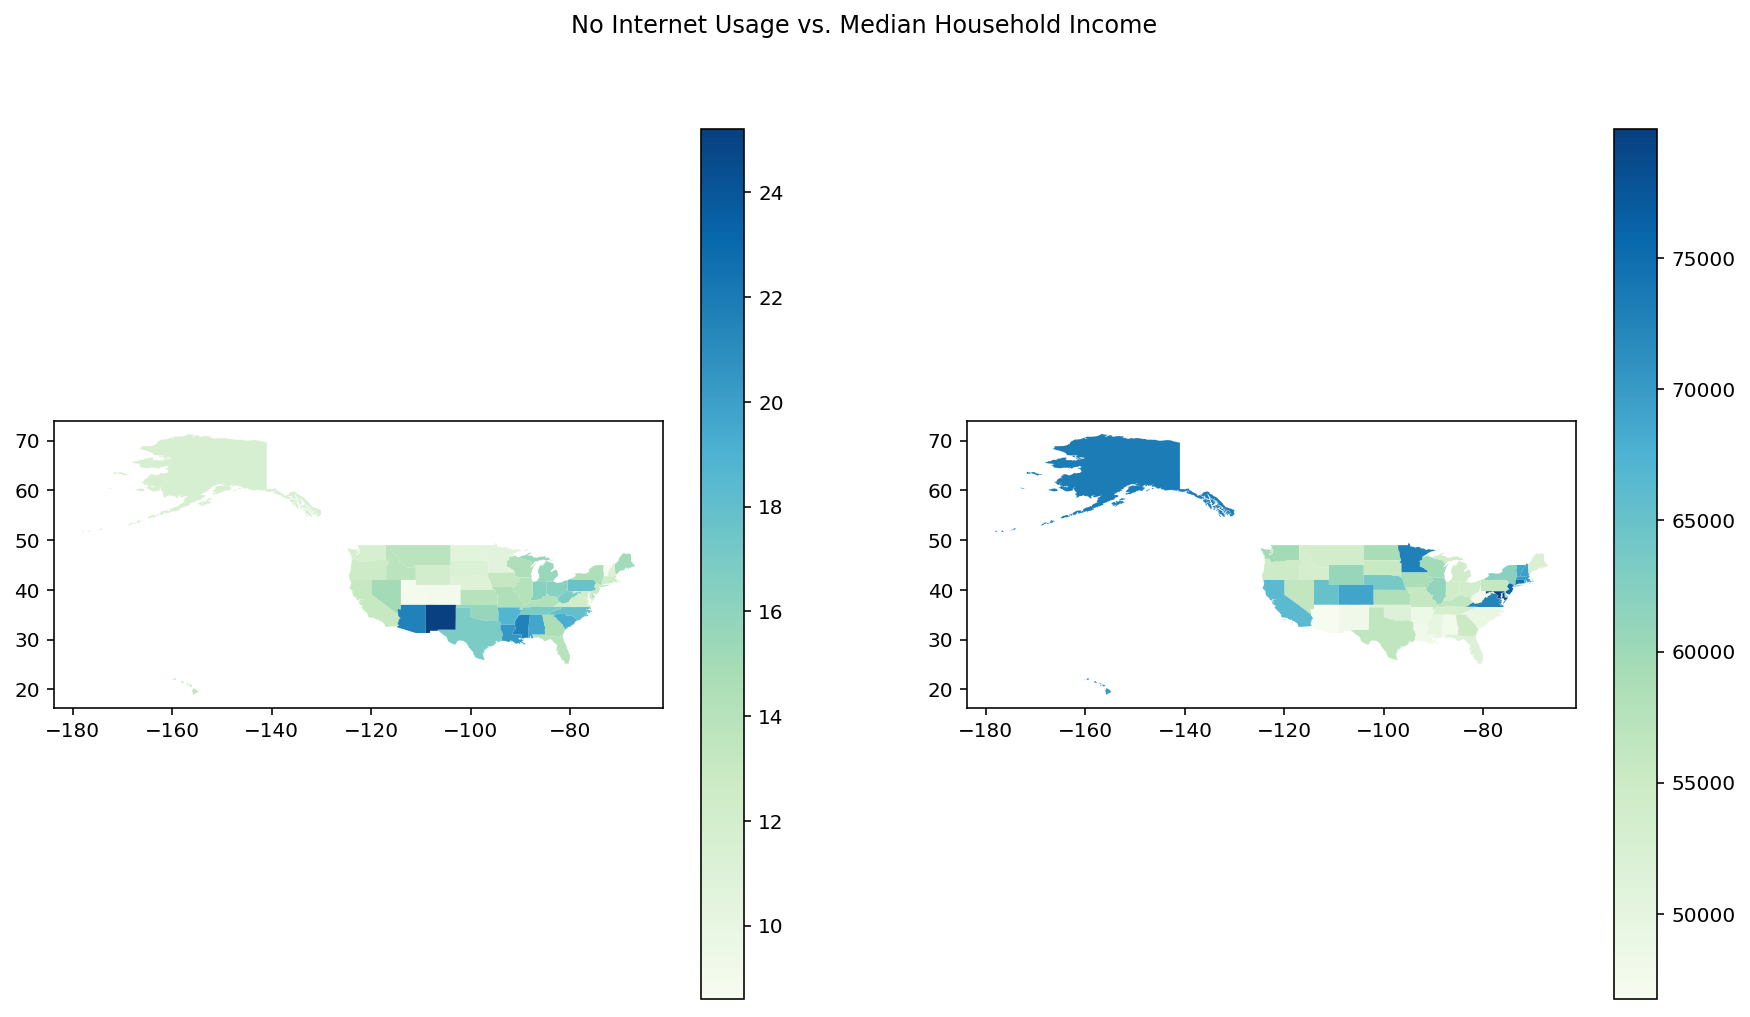

In [43]:

fig, ax = plt.subplots(nrows=1, ncols=2)
# This choropleth map plots no Internet usage percentage with green/blue color scale
new_df['avg(percent_no_internet)'] =  pd.to_numeric(new_df['avg(percent_no_internet)'])
new_df.plot(column='avg(percent_no_internet)',ax=ax[0], cmap='GnBu', legend=True);

# This choropleth map plots low educational level with green/blue color scale
new_df['avg(median_household_income)'] =  pd.to_numeric(new_df['avg(median_household_income)'])
new_df.plot(column='avg(median_household_income)',ax=ax[1], cmap='GnBu',legend=True);

fig.suptitle("No Internet Usage vs. Median Household Income")
fig.set_size_inches(15, 8)
plt.show()

### Analysis on Geospatial Map

For each group of choropleth maps, we have an average percentage of no internet usage summaried by state level on the left. On the right, we graphed out the comparing maps in the order of population below poverty, average of median age, percentage of population intensity, percentage of low education level (below high school), and median household income. While the chropleth of no internet usage  shows a concentration in southern part of the U.S, especially around Arizona and New Mexico area, neither the population below poverty nor the median age maps seem to reflect the tendency. On the other hand, with fairly low population density and high concentration of residents with low education level gathering across the southern part of the U.S(excluding Texas and Florida), these two factors do seem to play a role towards the causation of no internet accessibility. Finally, the chropleth of median household income encodes the fact that all states in southern part of the U.S have a below-average performance, which validates our prediction that the lower a state's average household income, the lower accessibility towards internet they would have. 

# Results
Our significance test will use an alpha value of .05. The OLS Regression Results are followed by analysis for each section.

### Education and Internet Usage Results

In [44]:
# Analyze correlation between education and internet usage (ABOVE HS)
outcome_1, predictors_1 = patsy.dmatrices('percent_no_internet ~ Percent_Population_Above_HS_Education', df)
mod_all = sm.OLS(outcome_1, predictors_1)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.509
Model:                             OLS   Adj. R-squared:                  0.508
Method:                  Least Squares   F-statistic:                     840.7
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):          1.94e-127
Time:                         15:05:00   Log-Likelihood:                -2306.4
No. Observations:                  814   AIC:                             4617.
Df Residuals:                      812   BIC:                             4626.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [45]:
# Analyze correlation between education and internet usage (BELOW HS)
outcome_1b, predictors_1b = patsy.dmatrices('percent_no_internet ~ Percent_Population_Below_HS_Education', df)
mod_all = sm.OLS(outcome_1b, predictors_1b)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.509
Model:                             OLS   Adj. R-squared:                  0.508
Method:                  Least Squares   F-statistic:                     840.7
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):          1.94e-127
Time:                         15:05:00   Log-Likelihood:                -2306.4
No. Observations:                  814   AIC:                             4617.
Df Residuals:                      812   BIC:                             4626.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

<b>ANALYSIS<br>
Both p values of 0.000 signify that education is statistically signifcant. We are using an alpha value of .05, but since p < .05, this shows that education and internet usage are related. Therefore, it is safe to reject the null hypothesis and accept our claim.

Furthermore, as previously seen, the slope value of 45.6258 indicates a positive relationship. The y intercept of -2.7099, along with the slope, models the line of best fit we graphed in our scatterplot.

R-squared value of .509 signifies that 51% of the variation in lack of internet access is explained by education.

### Poverty and Internet Usage Results

In [46]:
# Analyze correlation between poverty and internet usage (ALL ages)
outcome_2, predictors_2 = patsy.dmatrices('percent_no_internet ~ AllAgesinPovertyPercent', df)
mod_all = sm.OLS(outcome_2, predictors_2)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.459
Model:                             OLS   Adj. R-squared:                  0.458
Method:                  Least Squares   F-statistic:                     690.3
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):          1.15e-110
Time:                         15:05:00   Log-Likelihood:                -2353.0
No. Observations:                  816   AIC:                             4710.
Df Residuals:                      814   BIC:                             4719.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

In [47]:
# Analyze correlation between poverty and internet usage (under age 18)
outcome_2b, predictors_2b = patsy.dmatrices('percent_no_internet ~ UnderAge18inPovertyPercent', df)
mod_all = sm.OLS(outcome_2b, predictors_2b)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.550
Model:                             OLS   Adj. R-squared:                  0.550
Method:                  Least Squares   F-statistic:                     995.2
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):          2.53e-143
Time:                         15:05:00   Log-Likelihood:                -2277.7
No. Observations:                  816   AIC:                             4559.
Df Residuals:                      814   BIC:                             4569.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

<b>ANALYSIS<br>
Both p values of 0.000 signify that poverty levels is statistically signifcant. We are using an alpha value of .05, but since p < .05, this shows that poverty levels and internet usage are related. Therefore, it is safe to reject the null hypothesis and accept our claim.

Furthermore, as previously seen, the slope value of 0.5851 indicates a positive relationship. The y intercept of 4.8520, along with the slope, models the line of best fit we graphed in our scatterplot.

R-squared value of .550 signifies that 55% of the variation in lack of internet access is explained by poverty.

### Income and Internet Usage Results

In [48]:
outcome_3, predictors_3 = patsy.dmatrices('percent_no_internet ~ median_household_income', df)
mod_all = sm.OLS(outcome_3, predictors_3)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.497
Model:                             OLS   Adj. R-squared:                  0.497
Method:                  Least Squares   F-statistic:                     805.0
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):          1.15e-123
Time:                         15:05:00   Log-Likelihood:                -2323.0
No. Observations:                  816   AIC:                             4650.
Df Residuals:                      814   BIC:                             4659.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

<b>ANALYSIS<br>
The p value of 0.000 signifies that income level is statistically signifcant. We are using an alpha value of .05, but since p < .05, this shows that income levels and internet usage are related. Therefore, it is safe to reject the null hypothesis and accept our claim.

Furthermore, as previously seen, the slope value of -0.003 indicates a negative relationship. The y intercept of 31.0255, along with the slope, models the line of best fit we graphed in our scatterplot.

R-squared value of .497 signifies that 50% of the variation in lack of internet access is explained by income disparities.

### Income Inequality and Internet Usage Results

In [49]:
outcome_4, predictors_4 = patsy.dmatrices('percent_no_internet ~ gini_index', df)
mod_all = sm.OLS(outcome_4, predictors_4)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.056
Model:                             OLS   Adj. R-squared:                  0.055
Method:                  Least Squares   F-statistic:                     48.64
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):           6.36e-12
Time:                         15:05:00   Log-Likelihood:                -2579.9
No. Observations:                  816   AIC:                             5164.
Df Residuals:                      814   BIC:                             5173.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7391      2.588     -1.05

<b>ANALYSIS<br>
The p value of 0.000 signifies that income inequality is statistically signifcant. We are using an alpha value of .05, but since p < .05, this shows that income inequality and internet usage are related. Therefore, it is safe to reject the null hypothesis and accept our claim.


Furthermore, as previously seen, the slope value of 39.9040 indicates a positive relationship. The y intercept of -2.7391, along with the slope, models the line of best fit we graphed in our scatterplot.

R-squared value of .056 signifies that 6% of the variation in lack of internet access is explained by income inequality.

### Age and Internet Usage Results

In [50]:
outcome_5, predictors_5 = patsy.dmatrices('percent_no_internet ~ median_age', df)
mod_all = sm.OLS(outcome_5, predictors_5)
res_all = mod_all.fit()
print(res_all.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.005
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     3.846
Date:                 Tue, 11 Jun 2019   Prob (F-statistic):             0.0502
Time:                         15:05:01   Log-Likelihood:                -2601.6
No. Observations:                  816   AIC:                             5207.
Df Residuals:                      814   BIC:                             5217.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9525      1.699      7.03

<b>ANALYSIS<br>
The p value of 0.05 signifies that age is not statistically signifcant. We are using an alpha value of .05, but since p > .05, this shows that income age and internet usage cannot be proven to be related through this dataset. Therefore, it is safe to accept the null hypothesis and reject our claim, as there is not enough sufficient evidence to support our claim.


Furthermore, as previously seen, the slope value of 0.0855 indicates a  small positive relationship. The y intercept of 11.9525, along with the slope, models the line of best fit we graphed in our scatterplot.

R-squared value of .005 signifies that <1% of the variation in lack of internet access is explained by age.

# Ethics & Privacy

The US Census Bureau collects data about the economy and the people living in the United States. Their data is public on their website so we have permission to use it for our project. According to The US Census Bureau website, data are collected from a variety of sources; some are collected from surveys, some are collected as administrative data, which is data collected from the government for recordkeeping (A1). The data we have include a large population from all social-economic levels, not just a small sample, so it’s unlikely that we have collection bias in our dataset (A2) (C1). Furthermore, these data are confidential and protected by the federal law. No personal information is included in any of the data from the Census Bureau, including our particular dataset. It only shows summarized information that represent groups of people. Before releasing any statistics to the public, these data have been reviewed by the Census Bureau to make sure none of the information or characteristics could identify someone. Therefore, it cannot cause harm to any person or business (A3).

The dataset, however, is not complete because it has many missing values in the table, which can potentially yield incorrect results. Initially, race was one of the variables to study what affect Internet usage in United States, but later we had to drop it because our data is not complete on that variable. Another concern is that we only have data for large geographic areas over 65000 population, and it also only contains data in 2016, so our analysis may not reflect the current trend of Internet usage at the moment. One unintended use of our analysis could be the stereotype that is generalized from our results that some particular areas are conservative about Internet, and so not as developed as the rest of the country. A company could use it to make decisions on where to invest their business in. Therefore, it could do more harm to the states that already have disadvantage in Internet accessibility (E4). 

Reference checklist from http://deon.drivendata.org/examples/

# Conclusion & Discussion

Our project aims to answer why there are current internet disparities across United States Counties. While this topic has briefly been touched upon before, the underlying reasons by which such disparities exist have not been explored extensively. Upon background research and exploring multiple datasets, our main variables of interest were eventually narrowed down to certain socioeconomic factors: education, poverty, income, income inequality, and age. Our initial hypotheis was that lower levels of socioeconomic factors work in combination with one another to result in lower levels of internet access (refer to hypothesis above).

After cleaning the data set by removing null values and irrelevant columns, we visualized the data by means of scatter matrices, scatter plots, and geomaps for each of the five categories of interest. At the same time, we started exploring relationships between each of the socioeconomic factors with overall internet accessibility. By creating a line of best fit, and highlighting the outliers, it made it a lot easier to visualize the type of relationship that was present among the two variables. Furthermore, by using geopandas, we were able to explore the population density of those without internet access, in relation to each of the five socioeconomic factors. Following the geomaps, we perfomed significance tests to confirm our hypothesis with an alpha value of .05. Through each of the OLS Regression Results, we found that there was enough evidence to reject the null hypothesis for education, poverty, income and income inequality (accept our claim). Ultimately, this means that there was sufficient evidence to claim that these four socieconomic factors are related to the lack of internet accessibility across United States Counties. However, there was not enough evidence to support age as being related to the lack of internet accessibility. 

Some limitations to this project include the narrow scope of applicability, considering that this dataset had around 820 entries. The number of individuals that were surveyed within each county also varied, meaning that for all the tests we had done, it may have not been representative of the county (not as uniform as having an equal amount of entries for each county). Lastly, we have no information on how the data was collected, so potential biases could be pertinent within the dataset we are using. However, despite such limitations, our project aims to spread awareness of internet disparities across the United States. It's important to consider how in a relatively developed area such as the United States, there still exists a large percentage of individuals without internet. Through means of analyzing five socioeconomic factors, we hope that this research will be further developed and scrutinized on a larger scale. The internet is an essential tool to every individual, as it is a source of knowledge and networking. While this project only looks within the United States, we hope in the near future that such concerns can be addressed elsewhere in less developed areas across the globe. 